In [22]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [23]:
L = 7 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [24]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |2 2 2 2 2 2 2>           2186  
        1.         |2 2 2 2 2 2 1>           2185  
        2.         |2 2 2 2 2 2 0>           2184  
        3.         |2 2 2 2 2 1 2>           2183  
        4.         |2 2 2 2 2 1 1>           2182  
        5.         |2 2 2 2 2 1 0>           2181  
        6.         |2 2 2 2 2 0 2>           2180  
        7.         |2 2 2 2 2 0 1>           2179  
        8.         |2 2 2 2 2 0 0>           2178  
        9.         |2 2 2 2 1 2 2>           2177  
       10.         |2 2 2 2 1 2 1>           2176  
       11.         |2 2 2 2 1 2 0>           2175  
       12.         |2 2 2 2 1 1 2>           2174  
       13.         |2 2 2 2 1 1 1>           2173  
       14.         |2 2 2 2 1 1 0>           2172  
       15.         |2 2 2 2 1 0 2>           2171  
       16.         |2 2 2 2 1 0 1>           2170  
       17.         |2 2 2 2 1 0 0>           21

In [25]:
#initialisation of the Gauss laws
LL = 5 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[5]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste[6]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste_m[2]],
    ["I",liste[3]],
])

gauss_law_map.append([
    ["z",liste[3]],
    ["z",liste_m[4]],
    ["z",liste_m[6]],

])

gauss_law_map.append([
    ["z",liste[4]],
    ["z",liste_m[5]],
    ["I",liste[5]],

])
for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [26]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [27]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [28]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [29]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [30]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [31]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [32]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [33]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**0*M,2])
mass_term.append([2*(-1)**0*M,3])
mass_term.append([2*(-1)**1*M,4])
mass_term.append([2*(-1)**0*M,5])
mass_term.append([2*(-1)**1*M,6])

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = -0.5*(Proj[2]@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[3]+Proj[3]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@Proj[2])
interaction[3] = -0.5*(Proj[4]@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[2].tocsc()@Proj[4])
interaction[4] = 0.5*(Proj[5]@phase_ham[4].tocsc()@phase_ham[6].tocsc()@link_p_ham[4].tocsc()@Proj[4]+Proj[4]@link_m_ham[4].tocsc()@phase_ham[4].tocsc()@phase_ham[6].tocsc()@Proj[5])
interaction[5] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[5].tocsc()@link_p_ham[5].tocsc()@Proj[5]+Proj[5]@link_m_ham[5].tocsc()@phase_ham[5].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[6] = 0.5*(Proj[1]@phase_ham[1].tocsc()@phase_ham[6].tocsc()@link_p_ham[6].tocsc()@Proj[4]+Proj[4]@link_m_ham[6].tocsc()@phase_ham[6].tocsc()@phase_ham[1].tocsc()@Proj[1])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(4)]

plaquette[0] = 0.5*(Proj_0[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj_0[5]+Proj_0[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj_0[5])
plaquette[1] = -0.5*(Proj[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj[5]+Proj[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj[5])
plaquette[2] = -0.5*(Proj_0[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj_0[4]+Proj_0[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj_0[4])
plaquette[3] = 0.5*(Proj[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj[4]+Proj[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj[4])

h_plaq = 0

for i in range(4):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.6*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [34]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-1.6209751  -0.89907721 -0.7386169 ]


In [35]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [36]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.6209751  -0.89907721 -0.7386169 ]
(0.02995956086740631-0.00547219410997964j)|2 2 2 1 1 1 1>
(0.027859421154877616-0.0050885979612944965j)|2 2 2 1 1 1 0>
(-0.022752526229620165+0.004155809912298722j)|2 2 2 1 0 1 1>
(0.01895545319864913-0.003462264343750289j)|2 2 2 1 0 0 1>
(-0.04552181571500746+0.008314681678203453j)|2 2 2 0 1 1 0>
(0.021046852559591298-0.0038442640437868015j)|2 2 2 0 0 1 1>
(-0.01285377449874765+0.002347776371434583j)|2 2 2 0 0 1 0>
(-0.03443248357071484+0.00628918543304246j)|2 2 2 0 0 0 1>
(-0.005409152085989955+0.000987996129714326j)|2 2 2 0 0 0 0>
(0.1004817196732091-0.01835325547627043j)|2 1 2 1 1 1 1>
(0.018284575255695556-0.0033397266889368476j)|2 1 2 1 0 1 2>
(-0.04402716758011661+0.008041680189415366j)|2 1 2 1 0 1 1>
(-0.04461901673005277+0.00814978302331951j)|2 1 2 1 0 0 2>
(-0.002005257697890831+0.0003662656943459965j)|2 1 2 1 0 0 1>
(0.022752526229619995-0.004155809912298766j)|2 1 2 0 0 1 1>
(-0.018955453198648962+0.0034622643437504175j)|2 1 2 0 0 0 1>
(

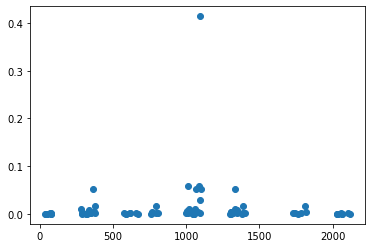

In [37]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [38]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [39]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [40]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [41]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 6.34 ms, sys: 272 µs, total: 6.61 ms
Wall time: 6.9 ms


<2187x2187 sparse matrix of type '<class 'numpy.complex128'>'
	with 2916 stored elements in COOrdinate format>

In [42]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [43]:
def R(i,theta):
    
    if i%27 == 0:
        return(exp_gate(0,theta))

    if i%27 == 1:
        return(exp_gate(1,theta))

    if i%27 == 2:
        return(exp_gate(2,theta))
    
    if i%27 == 3:
        return(exp_gate(3,theta))

    if i%27 == 4:
        return(exp_gate(4,theta))

    if i%27 == 5:
        return(exp_gate(5,theta))

    if i%27 == 6:
        return(rot_sigma(0,0,1,0,theta))


    if i%27 == 7:
        return(rot_sigma(0,0,2,0,theta))

    
    if i%27 == 8:
        return(rot_sigma(0,1,2,np.pi/2,theta))

    
    if i%27 == 9:
        return(rot_sigma(1,0,1,0,theta))


    if i%27 == 10:
        return(rot_sigma(1,0,2,0,theta))

    
    if i%27 == 11:
        return(rot_sigma(1,1,2,np.pi/2,theta))

    if i%27 == 12:
        return(rot_sigma(2,0,1,0,theta))


    if i%27 == 13:
        return(rot_sigma(2,0,2,0,theta))

    
    if i%27 == 14:
        return(rot_sigma(2,1,2,np.pi/2,theta))

    
    if i%27 == 15:
        return(rot_sigma(3,0,1,0,theta))


    if i%27 == 16:
        return(rot_sigma(3,0,2,0,theta))

    
    if i%27 == 17:
        return(rot_sigma(3,1,2,np.pi/2,theta))
    
    if i%27 == 18:
        return(rot_sigma(4,0,1,0,theta))


    if i%27 == 19:
        return(rot_sigma(4,0,2,0,theta))

    
    if i%27 == 20:
        return(rot_sigma(4,1,2,np.pi/2,theta))     

    if i%27 == 21:
        return(rot_sigma(5,0,1,0,theta))


    if i%27 == 22:
        return(rot_sigma(5,0,2,0,theta))

    
    if i%27 == 23:
        return(rot_sigma(5,1,2,np.pi/2,theta))
    
    if i%27 == 24:
        return(rot_sigma(6,0,1,0,theta))


    if i%27 == 25:
        return(rot_sigma(6,0,2,0,theta))

    
    if i%27 == 26:
        return(rot_sigma(6,1,2,np.pi/2,theta))

def S(i,theta):
    
    if i%27 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%27 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%27 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())

    if i%27 == 3:
        return(exp_gate_der(3,theta)@exp_gate(3,theta).T.conj())

    if i%27 == 4:
        return(exp_gate_der(4,theta)@exp_gate(4,theta).T.conj())
    
    if i%27 == 5:
        return(exp_gate_der(5,theta)@exp_gate(5,theta).T.conj())

    if i%27 == 6:
        return(-1j*sigma(0,0,1,0))

    
    if i%27 == 7:
        return(-1j*sigma(0,0,2,0))

    
    if i%27 == 8:
        return(-1j*sigma(0,1,2,np.pi/2))
     
    if i%27 == 9:
        return(-1j*sigma(1,0,1,0))

    
    if i%27 == 10:
        return(-1j*sigma(1,0,2,0))

    
    if i%27 == 11:
        return(-1j*sigma(1,1,2,np.pi/2))

     
    if i%27 == 12:
        return(-1j*sigma(2,0,1,0))

    
    if i%27 == 13:
        return(-1j*sigma(2,0,2,0))
    

    if i%27 == 14:
        return(-1j*sigma(2,1,2,np.pi/2))
    
     
    if i%27 == 15:
        return(-1j*sigma(3,0,1,0))

    
    if i%27 == 16:
        return(-1j*sigma(3,0,2,0))
    

    if i%27 == 17:
        return(-1j*sigma(3,1,2,np.pi/2))

    if i%27 == 18:
        return(-1j*sigma(4,0,1,0))

    
    if i%27 == 19:
        return(-1j*sigma(4,0,2,0))
    

    if i%27 == 20:
        return(-1j*sigma(4,1,2,np.pi/2))
    
    if i%27 == 21:
        return(-1j*sigma(5,0,1,0))

    
    if i%27 == 22:
        return(-1j*sigma(5,0,2,0))
    

    if i%27 == 23:
        return(-1j*sigma(5,1,2,np.pi/2))
    
    if i%27 == 24:
        return(-1j*sigma(6,0,1,0))

    
    if i%27 == 25:
        return(-1j*sigma(6,0,2,0))
    

    if i%27 == 26:
        return(-1j*sigma(6,1,2,np.pi/2))

In [44]:
coeff = 27
stepp = 1500
t_final = 30

In [45]:
expt_value = []
energyy = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [46]:
for kkk in range(1):
    
    N=3
    start_point = np.random.rand(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b

        for i in range(LL+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(LL+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.real(Y+YY)
        result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(LL+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-17 15:29:59.598763
start 2022-08-17 15:29:59.853022
stop_reduce 2022-08-17 15:30:00.657392
2022-08-17 15:30:01.712174
0
2022-08-17 15:30:01.712577
start 2022-08-17 15:30:01.997626
stop_reduce 2022-08-17 15:30:02.793457
2022-08-17 15:30:03.790567
0.01
2022-08-17 15:30:03.791103
start 2022-08-17 15:30:04.060160
stop_reduce 2022-08-17 15:30:04.850450
2022-08-17 15:30:05.851779
0.01
2022-08-17 15:30:05.852310
start 2022-08-17 15:30:06.119727
stop_reduce 2022-08-17 15:30:06.903411
2022-08-17 15:30:07.910728
0.02
2022-08-17 15:30:07.911620
start 2022-08-17 15:30:08.212116
stop_reduce 2022-08-17 15:30:09.079205
2022-08-17 15:30:10.095986
0.02
2022-08-17 15:30:10.096852
start 2022-08-17 15:30:10.414689
stop_reduce 2022-08-17 15:30:11.364314
2022-08-17 15:30:12.427274
0.03
2022-08-17 15:30:12.427931
start 2022-08-17 15:30:12.746442
stop_reduce 2022-08-17 15:30:13.667005
2022-08-17 15:30:14.714415
0.03
2022-08-17 15:30:14.714898
start 2022-08-17 15:30:15.032524
stop_reduce 2022-08-17 15:

start 2022-08-17 15:32:19.033215
stop_reduce 2022-08-17 15:32:20.001506
2022-08-17 15:32:21.099092
0.3
2022-08-17 15:32:21.099777
start 2022-08-17 15:32:21.432286
stop_reduce 2022-08-17 15:32:22.400273
2022-08-17 15:32:23.513136
0.31
2022-08-17 15:32:23.513719
start 2022-08-17 15:32:23.844853
stop_reduce 2022-08-17 15:32:24.802875
2022-08-17 15:32:25.919499
0.31
2022-08-17 15:32:25.920326
start 2022-08-17 15:32:26.250639
stop_reduce 2022-08-17 15:32:27.216740
2022-08-17 15:32:28.317966
0.32
2022-08-17 15:32:28.319090
start 2022-08-17 15:32:28.646343
stop_reduce 2022-08-17 15:32:29.613574
2022-08-17 15:32:30.728242
0.32
2022-08-17 15:32:30.729285
start 2022-08-17 15:32:31.056301
stop_reduce 2022-08-17 15:32:32.025122
2022-08-17 15:32:33.166158
0.33
2022-08-17 15:32:33.167084
start 2022-08-17 15:32:33.509867
stop_reduce 2022-08-17 15:32:34.478316
2022-08-17 15:32:35.591098
0.33
2022-08-17 15:32:35.591694
start 2022-08-17 15:32:35.918620
stop_reduce 2022-08-17 15:32:36.880371
2022-08-17 1

2022-08-17 15:34:38.930203
0.5900000000000002
2022-08-17 15:34:38.930636
start 2022-08-17 15:34:39.260590
stop_reduce 2022-08-17 15:34:40.227878
2022-08-17 15:34:41.328248
0.5900000000000002
2022-08-17 15:34:41.328672
start 2022-08-17 15:34:41.658908
stop_reduce 2022-08-17 15:34:42.645863
2022-08-17 15:34:43.766821
0.6000000000000002
2022-08-17 15:34:43.767439
start 2022-08-17 15:34:44.097170
stop_reduce 2022-08-17 15:34:45.061262
2022-08-17 15:34:46.159484
0.6000000000000002
2022-08-17 15:34:46.160205
start 2022-08-17 15:34:46.503992
stop_reduce 2022-08-17 15:34:47.525342
2022-08-17 15:34:48.798039
0.6100000000000002
2022-08-17 15:34:48.798636
start 2022-08-17 15:34:49.181170
stop_reduce 2022-08-17 15:34:50.198721
2022-08-17 15:34:51.381617
0.6100000000000002
2022-08-17 15:34:51.382271
start 2022-08-17 15:34:51.743564
stop_reduce 2022-08-17 15:34:52.840253
2022-08-17 15:34:54.126106
0.6200000000000002
2022-08-17 15:34:54.126949
start 2022-08-17 15:34:54.507252
stop_reduce 2022-08-17 1

start 2022-08-17 15:37:08.936439
stop_reduce 2022-08-17 15:37:10.017884
2022-08-17 15:37:11.242847
0.8700000000000004
2022-08-17 15:37:11.243366
start 2022-08-17 15:37:11.667842
stop_reduce 2022-08-17 15:37:12.739814
2022-08-17 15:37:14.032364
0.8800000000000004
2022-08-17 15:37:14.032964
start 2022-08-17 15:37:14.497399
stop_reduce 2022-08-17 15:37:15.619485
2022-08-17 15:37:16.804270
0.8800000000000004
2022-08-17 15:37:16.805436
start 2022-08-17 15:37:17.228511
stop_reduce 2022-08-17 15:37:18.363160
2022-08-17 15:37:19.603512
0.8900000000000005
2022-08-17 15:37:19.604085
start 2022-08-17 15:37:19.938069
stop_reduce 2022-08-17 15:37:20.888307
2022-08-17 15:37:21.995611
0.8900000000000005
2022-08-17 15:37:21.996364
start 2022-08-17 15:37:22.364505
stop_reduce 2022-08-17 15:37:23.569039
2022-08-17 15:37:24.755131
0.9000000000000005
2022-08-17 15:37:24.755792
start 2022-08-17 15:37:25.113255
stop_reduce 2022-08-17 15:37:26.195170
2022-08-17 15:37:27.414884
0.9000000000000005
2022-08-17 1

start 2022-08-17 15:39:35.306283
stop_reduce 2022-08-17 15:39:36.274709
2022-08-17 15:39:37.364850
1.1600000000000006
2022-08-17 15:39:37.365756
start 2022-08-17 15:39:37.698165
stop_reduce 2022-08-17 15:39:38.661304
2022-08-17 15:39:39.856119
1.1600000000000006
2022-08-17 15:39:39.856904
start 2022-08-17 15:39:40.250619
stop_reduce 2022-08-17 15:39:41.434817
2022-08-17 15:39:42.913596
1.1700000000000006
2022-08-17 15:39:42.914108
start 2022-08-17 15:39:43.320126
stop_reduce 2022-08-17 15:39:44.722338
2022-08-17 15:39:46.141759
1.1700000000000006
2022-08-17 15:39:46.142278
start 2022-08-17 15:39:46.585375
stop_reduce 2022-08-17 15:39:47.656516
2022-08-17 15:39:48.767674
1.1800000000000006
2022-08-17 15:39:48.768150
start 2022-08-17 15:39:49.207511
stop_reduce 2022-08-17 15:39:50.268666
2022-08-17 15:39:51.460151
1.1800000000000006
2022-08-17 15:39:51.461418
start 2022-08-17 15:39:51.867312
stop_reduce 2022-08-17 15:39:52.857147
2022-08-17 15:39:53.960090
1.1900000000000006
2022-08-17 1

start 2022-08-17 15:42:03.124751
stop_reduce 2022-08-17 15:42:04.221676
2022-08-17 15:42:05.410044
1.4400000000000008
2022-08-17 15:42:05.411044
start 2022-08-17 15:42:05.787465
stop_reduce 2022-08-17 15:42:06.833835
2022-08-17 15:42:08.184184
1.4500000000000008
2022-08-17 15:42:08.184731
start 2022-08-17 15:42:08.539389
stop_reduce 2022-08-17 15:42:09.681310
2022-08-17 15:42:10.907094
1.4500000000000008
2022-08-17 15:42:10.908159
start 2022-08-17 15:42:11.267189
stop_reduce 2022-08-17 15:42:12.318402
2022-08-17 15:42:13.645338
1.4600000000000009
2022-08-17 15:42:13.645991
start 2022-08-17 15:42:14.055950
stop_reduce 2022-08-17 15:42:15.133322
2022-08-17 15:42:16.442934
1.4600000000000009
2022-08-17 15:42:16.443694
start 2022-08-17 15:42:16.922456
stop_reduce 2022-08-17 15:42:18.077681
2022-08-17 15:42:19.342139
1.4700000000000009
2022-08-17 15:42:19.342822
start 2022-08-17 15:42:19.750617
stop_reduce 2022-08-17 15:42:20.994349
2022-08-17 15:42:22.111273
1.4700000000000009
2022-08-17 1

start 2022-08-17 15:44:28.711421
stop_reduce 2022-08-17 15:44:29.684380
2022-08-17 15:44:30.787829
1.730000000000001
2022-08-17 15:44:30.788396
start 2022-08-17 15:44:31.126823
stop_reduce 2022-08-17 15:44:32.101806
2022-08-17 15:44:33.222194
1.730000000000001
2022-08-17 15:44:33.222763
start 2022-08-17 15:44:33.555104
stop_reduce 2022-08-17 15:44:34.522991
2022-08-17 15:44:35.638739
1.740000000000001
2022-08-17 15:44:35.639875
start 2022-08-17 15:44:35.970608
stop_reduce 2022-08-17 15:44:36.944099
2022-08-17 15:44:38.063031
1.740000000000001
2022-08-17 15:44:38.063482
start 2022-08-17 15:44:38.392681
stop_reduce 2022-08-17 15:44:39.363378
2022-08-17 15:44:40.460905
1.750000000000001
2022-08-17 15:44:40.462208
start 2022-08-17 15:44:40.789599
stop_reduce 2022-08-17 15:44:41.761654
2022-08-17 15:44:42.874127
1.750000000000001
2022-08-17 15:44:42.874899
start 2022-08-17 15:44:43.208858
stop_reduce 2022-08-17 15:44:44.180408
2022-08-17 15:44:45.290079
1.7600000000000011
2022-08-17 15:44:4

start 2022-08-17 15:46:47.513050
stop_reduce 2022-08-17 15:46:48.500468
2022-08-17 15:46:49.622432
2.010000000000001
2022-08-17 15:46:49.623065
start 2022-08-17 15:46:49.958090
stop_reduce 2022-08-17 15:46:50.945269
2022-08-17 15:46:52.086744
2.0200000000000014
2022-08-17 15:46:52.087539
start 2022-08-17 15:46:52.428252
stop_reduce 2022-08-17 15:46:53.423387
2022-08-17 15:46:54.563981
2.0200000000000014
2022-08-17 15:46:54.564420
start 2022-08-17 15:46:54.896491
stop_reduce 2022-08-17 15:46:55.880376
2022-08-17 15:46:57.010602
2.030000000000001
2022-08-17 15:46:57.011202
start 2022-08-17 15:46:57.346926
stop_reduce 2022-08-17 15:46:58.333846
2022-08-17 15:46:59.464256
2.030000000000001
2022-08-17 15:46:59.465306
start 2022-08-17 15:46:59.810731
stop_reduce 2022-08-17 15:47:00.791852
2022-08-17 15:47:01.909096
2.0400000000000014
2022-08-17 15:47:01.909952
start 2022-08-17 15:47:02.246123
stop_reduce 2022-08-17 15:47:03.230831
2022-08-17 15:47:04.347354
2.0400000000000014
2022-08-17 15:4

start 2022-08-17 15:49:08.070103
stop_reduce 2022-08-17 15:49:09.381749
2022-08-17 15:49:10.931294
2.3000000000000016
2022-08-17 15:49:10.932282
start 2022-08-17 15:49:11.330899
stop_reduce 2022-08-17 15:49:12.416288
2022-08-17 15:49:14.097331
2.3000000000000016
2022-08-17 15:49:14.099109
start 2022-08-17 15:49:14.620678
stop_reduce 2022-08-17 15:49:16.145632
2022-08-17 15:49:17.905802
2.3100000000000014
2022-08-17 15:49:17.906398
start 2022-08-17 15:49:18.415959
stop_reduce 2022-08-17 15:49:19.689630
2022-08-17 15:49:21.069642
2.3100000000000014
2022-08-17 15:49:21.070151
start 2022-08-17 15:49:21.465508
stop_reduce 2022-08-17 15:49:22.673990
2022-08-17 15:49:24.061068
2.3200000000000016
2022-08-17 15:49:24.061481
start 2022-08-17 15:49:24.472978
stop_reduce 2022-08-17 15:49:25.665696
2022-08-17 15:49:27.045570
2.3200000000000016
2022-08-17 15:49:27.046495
start 2022-08-17 15:49:27.491106
stop_reduce 2022-08-17 15:49:28.731903
2022-08-17 15:49:29.996008
2.3300000000000014
2022-08-17 1

start 2022-08-17 15:51:37.846244
stop_reduce 2022-08-17 15:51:38.828089
2022-08-17 15:51:39.938604
2.580000000000002
2022-08-17 15:51:39.939034
start 2022-08-17 15:51:40.271758
stop_reduce 2022-08-17 15:51:41.246052
2022-08-17 15:51:42.348529
2.5900000000000016
2022-08-17 15:51:42.349085
start 2022-08-17 15:51:42.683084
stop_reduce 2022-08-17 15:51:43.655401
2022-08-17 15:51:44.755643
2.5900000000000016
2022-08-17 15:51:44.756211
start 2022-08-17 15:51:45.090571
stop_reduce 2022-08-17 15:51:46.065685
2022-08-17 15:51:47.163317
2.600000000000002
2022-08-17 15:51:47.163991
start 2022-08-17 15:51:47.500192
stop_reduce 2022-08-17 15:51:48.470830
2022-08-17 15:51:49.570826
2.600000000000002
2022-08-17 15:51:49.571396
start 2022-08-17 15:51:49.903152
stop_reduce 2022-08-17 15:51:50.879787
2022-08-17 15:51:51.992825
2.6100000000000017
2022-08-17 15:51:51.993264
start 2022-08-17 15:51:52.326654
stop_reduce 2022-08-17 15:51:53.298153
2022-08-17 15:51:54.407959
2.6100000000000017
2022-08-17 15:5

start 2022-08-17 15:53:55.651640
stop_reduce 2022-08-17 15:53:56.628618
2022-08-17 15:53:57.748928
2.870000000000002
2022-08-17 15:53:57.749679
start 2022-08-17 15:53:58.077144
stop_reduce 2022-08-17 15:53:59.046516
2022-08-17 15:54:00.163947
2.870000000000002
2022-08-17 15:54:00.164329
start 2022-08-17 15:54:00.502346
stop_reduce 2022-08-17 15:54:01.475961
2022-08-17 15:54:02.602262
2.880000000000002
2022-08-17 15:54:02.602640
start 2022-08-17 15:54:02.932230
stop_reduce 2022-08-17 15:54:03.903956
2022-08-17 15:54:05.023515
2.880000000000002
2022-08-17 15:54:05.024167
start 2022-08-17 15:54:05.358260
stop_reduce 2022-08-17 15:54:06.339936
2022-08-17 15:54:07.445859
2.890000000000002
2022-08-17 15:54:07.446349
start 2022-08-17 15:54:07.774790
stop_reduce 2022-08-17 15:54:08.744260
2022-08-17 15:54:09.843139
2.890000000000002
2022-08-17 15:54:09.844198
start 2022-08-17 15:54:10.174094
stop_reduce 2022-08-17 15:54:11.150395
2022-08-17 15:54:12.265330
2.900000000000002
2022-08-17 15:54:12

start 2022-08-17 15:56:13.587192
stop_reduce 2022-08-17 15:56:14.565961
2022-08-17 15:56:15.687943
3.150000000000002
2022-08-17 15:56:15.688374
start 2022-08-17 15:56:16.022910
stop_reduce 2022-08-17 15:56:16.999168
2022-08-17 15:56:18.118366
3.1600000000000024
2022-08-17 15:56:18.118890
start 2022-08-17 15:56:18.458126
stop_reduce 2022-08-17 15:56:19.441412
2022-08-17 15:56:20.586825
3.1600000000000024
2022-08-17 15:56:20.588017
start 2022-08-17 15:56:20.930324
stop_reduce 2022-08-17 15:56:21.922641
2022-08-17 15:56:23.066841
3.170000000000002
2022-08-17 15:56:23.067738
start 2022-08-17 15:56:23.403145
stop_reduce 2022-08-17 15:56:24.378927
2022-08-17 15:56:25.493617
3.170000000000002
2022-08-17 15:56:25.494611
start 2022-08-17 15:56:25.825022
stop_reduce 2022-08-17 15:56:26.796637
2022-08-17 15:56:27.917170
3.1800000000000024
2022-08-17 15:56:27.918061
start 2022-08-17 15:56:28.251319
stop_reduce 2022-08-17 15:56:29.221972
2022-08-17 15:56:30.338290
3.1800000000000024
2022-08-17 15:5

start 2022-08-17 15:58:31.427125
stop_reduce 2022-08-17 15:58:32.404518
2022-08-17 15:58:33.519299
3.4400000000000026
2022-08-17 15:58:33.520341
start 2022-08-17 15:58:33.854521
stop_reduce 2022-08-17 15:58:34.827491
2022-08-17 15:58:35.942216
3.4400000000000026
2022-08-17 15:58:35.943035
start 2022-08-17 15:58:36.271893
stop_reduce 2022-08-17 15:58:37.243213
2022-08-17 15:58:38.360641
3.4500000000000024
2022-08-17 15:58:38.361658
start 2022-08-17 15:58:38.693442
stop_reduce 2022-08-17 15:58:39.660403
2022-08-17 15:58:40.770526
3.4500000000000024
2022-08-17 15:58:40.771150
start 2022-08-17 15:58:41.101879
stop_reduce 2022-08-17 15:58:42.076512
2022-08-17 15:58:43.189828
3.4600000000000026
2022-08-17 15:58:43.190633
start 2022-08-17 15:58:43.521566
stop_reduce 2022-08-17 15:58:44.493530
2022-08-17 15:58:45.596976
3.4600000000000026
2022-08-17 15:58:45.597711
start 2022-08-17 15:58:45.927112
stop_reduce 2022-08-17 15:58:46.898793
2022-08-17 15:58:48.109628
3.4700000000000024
2022-08-17 1

start 2022-08-17 16:00:49.165806
stop_reduce 2022-08-17 16:00:50.131151
2022-08-17 16:00:51.233979
3.720000000000003
2022-08-17 16:00:51.234771
start 2022-08-17 16:00:51.562603
stop_reduce 2022-08-17 16:00:52.526715
2022-08-17 16:00:53.651508
3.7300000000000026
2022-08-17 16:00:53.652741
start 2022-08-17 16:00:53.983004
stop_reduce 2022-08-17 16:00:54.946162
2022-08-17 16:00:56.037196
3.7300000000000026
2022-08-17 16:00:56.038004
start 2022-08-17 16:00:56.370103
stop_reduce 2022-08-17 16:00:57.335209
2022-08-17 16:00:58.444544
3.740000000000003
2022-08-17 16:00:58.445166
start 2022-08-17 16:00:58.776761
stop_reduce 2022-08-17 16:00:59.740632
2022-08-17 16:01:00.844303
3.740000000000003
2022-08-17 16:01:00.845455
start 2022-08-17 16:01:01.175003
stop_reduce 2022-08-17 16:01:02.139932
2022-08-17 16:01:03.244833
3.7500000000000027
2022-08-17 16:01:03.245288
start 2022-08-17 16:01:03.575365
stop_reduce 2022-08-17 16:01:04.543993
2022-08-17 16:01:05.643097
3.7500000000000027
2022-08-17 16:0

start 2022-08-17 16:03:07.009370
stop_reduce 2022-08-17 16:03:07.984295
2022-08-17 16:03:09.102886
4.0100000000000025
2022-08-17 16:03:09.103764
start 2022-08-17 16:03:09.443692
stop_reduce 2022-08-17 16:03:10.422389
2022-08-17 16:03:11.545336
4.0100000000000025
2022-08-17 16:03:11.545939
start 2022-08-17 16:03:11.875253
stop_reduce 2022-08-17 16:03:12.850193
2022-08-17 16:03:13.962106
4.020000000000002
2022-08-17 16:03:13.962920
start 2022-08-17 16:03:14.300696
stop_reduce 2022-08-17 16:03:15.274493
2022-08-17 16:03:16.406079
4.020000000000002
2022-08-17 16:03:16.406526
start 2022-08-17 16:03:16.738738
stop_reduce 2022-08-17 16:03:17.719312
2022-08-17 16:03:18.836006
4.030000000000002
2022-08-17 16:03:18.836474
start 2022-08-17 16:03:19.170848
stop_reduce 2022-08-17 16:03:20.147795
2022-08-17 16:03:21.267129
4.030000000000002
2022-08-17 16:03:21.267926
start 2022-08-17 16:03:21.609052
stop_reduce 2022-08-17 16:03:22.589602
2022-08-17 16:03:23.714476
4.040000000000002
2022-08-17 16:03:

start 2022-08-17 16:05:28.276685
stop_reduce 2022-08-17 16:05:29.265661
2022-08-17 16:05:30.371313
4.299999999999996
2022-08-17 16:05:30.372231
start 2022-08-17 16:05:30.703968
stop_reduce 2022-08-17 16:05:31.675637
2022-08-17 16:05:32.791877
4.299999999999996
2022-08-17 16:05:32.793013
start 2022-08-17 16:05:33.130447
stop_reduce 2022-08-17 16:05:34.110672
2022-08-17 16:05:35.227249
4.309999999999996
2022-08-17 16:05:35.227690
start 2022-08-17 16:05:35.557977
stop_reduce 2022-08-17 16:05:36.545650
2022-08-17 16:05:37.684667
4.309999999999996
2022-08-17 16:05:37.685363
start 2022-08-17 16:05:38.018423
stop_reduce 2022-08-17 16:05:38.997377
2022-08-17 16:05:40.120002
4.319999999999996
2022-08-17 16:05:40.120964
start 2022-08-17 16:05:40.454828
stop_reduce 2022-08-17 16:05:41.432515
2022-08-17 16:05:42.540513
4.319999999999996
2022-08-17 16:05:42.540953
start 2022-08-17 16:05:42.873716
stop_reduce 2022-08-17 16:05:43.853160
2022-08-17 16:05:44.978510
4.329999999999996
2022-08-17 16:05:44

start 2022-08-17 16:07:46.596721
stop_reduce 2022-08-17 16:07:47.559655
2022-08-17 16:07:48.646478
4.57999999999999
2022-08-17 16:07:48.647087
start 2022-08-17 16:07:48.977015
stop_reduce 2022-08-17 16:07:49.944137
2022-08-17 16:07:51.029711
4.58999999999999
2022-08-17 16:07:51.030817
start 2022-08-17 16:07:51.358425
stop_reduce 2022-08-17 16:07:52.321025
2022-08-17 16:07:53.471509
4.58999999999999
2022-08-17 16:07:53.472236
start 2022-08-17 16:07:53.822709
stop_reduce 2022-08-17 16:07:54.791767
2022-08-17 16:07:55.896302
4.59999999999999
2022-08-17 16:07:55.896909
start 2022-08-17 16:07:56.226134
stop_reduce 2022-08-17 16:07:57.185159
2022-08-17 16:07:58.277951
4.59999999999999
2022-08-17 16:07:58.278994
start 2022-08-17 16:07:58.605605
stop_reduce 2022-08-17 16:07:59.576414
2022-08-17 16:08:00.682936
4.60999999999999
2022-08-17 16:08:00.683548
start 2022-08-17 16:08:01.013551
stop_reduce 2022-08-17 16:08:01.976102
2022-08-17 16:08:03.063327
4.60999999999999
2022-08-17 16:08:03.064230

start 2022-08-17 16:10:03.485345
stop_reduce 2022-08-17 16:10:04.440137
2022-08-17 16:10:05.531719
4.869999999999984
2022-08-17 16:10:05.532330
start 2022-08-17 16:10:05.858691
stop_reduce 2022-08-17 16:10:06.824533
2022-08-17 16:10:07.925780
4.869999999999984
2022-08-17 16:10:07.926475
start 2022-08-17 16:10:08.253820
stop_reduce 2022-08-17 16:10:09.217012
2022-08-17 16:10:10.318068
4.879999999999984
2022-08-17 16:10:10.318540
start 2022-08-17 16:10:10.644760
stop_reduce 2022-08-17 16:10:11.606334
2022-08-17 16:10:12.702848
4.879999999999984
2022-08-17 16:10:12.703292
start 2022-08-17 16:10:13.031569
stop_reduce 2022-08-17 16:10:13.996535
2022-08-17 16:10:15.095380
4.889999999999984
2022-08-17 16:10:15.096002
start 2022-08-17 16:10:15.420698
stop_reduce 2022-08-17 16:10:16.382736
2022-08-17 16:10:17.467946
4.889999999999984
2022-08-17 16:10:17.468674
start 2022-08-17 16:10:17.798789
stop_reduce 2022-08-17 16:10:18.758926
2022-08-17 16:10:19.850678
4.8999999999999835
2022-08-17 16:10:1

start 2022-08-17 16:12:28.696735
stop_reduce 2022-08-17 16:12:29.799724
2022-08-17 16:12:31.036013
5.149999999999978
2022-08-17 16:12:31.036486
start 2022-08-17 16:12:31.378252
stop_reduce 2022-08-17 16:12:32.353573
2022-08-17 16:12:33.481143
5.159999999999978
2022-08-17 16:12:33.481757
start 2022-08-17 16:12:33.850392
stop_reduce 2022-08-17 16:12:34.988027
2022-08-17 16:12:36.282674
5.159999999999978
2022-08-17 16:12:36.283382
start 2022-08-17 16:12:36.628642
stop_reduce 2022-08-17 16:12:37.613032
2022-08-17 16:12:38.756827
5.169999999999978
2022-08-17 16:12:38.757405
start 2022-08-17 16:12:39.092009
stop_reduce 2022-08-17 16:12:40.081608
2022-08-17 16:12:41.223142
5.169999999999978
2022-08-17 16:12:41.223855
start 2022-08-17 16:12:41.564535
stop_reduce 2022-08-17 16:12:42.550705
2022-08-17 16:12:43.667457
5.1799999999999775
2022-08-17 16:12:43.668042
start 2022-08-17 16:12:44.002395
stop_reduce 2022-08-17 16:12:44.983161
2022-08-17 16:12:46.098740
5.1799999999999775
2022-08-17 16:12:

start 2022-08-17 16:14:59.530341
stop_reduce 2022-08-17 16:15:00.997007
2022-08-17 16:15:02.743682
5.439999999999972
2022-08-17 16:15:02.744656
start 2022-08-17 16:15:03.296129
stop_reduce 2022-08-17 16:15:04.631217
2022-08-17 16:15:06.263276
5.439999999999972
2022-08-17 16:15:06.264049
start 2022-08-17 16:15:06.784604
stop_reduce 2022-08-17 16:15:08.062624
2022-08-17 16:15:09.680994
5.449999999999972
2022-08-17 16:15:09.681834
start 2022-08-17 16:15:10.223807
stop_reduce 2022-08-17 16:15:11.694639
2022-08-17 16:15:13.382747
5.449999999999972
2022-08-17 16:15:13.383573
start 2022-08-17 16:15:13.928009
stop_reduce 2022-08-17 16:15:15.300911
2022-08-17 16:15:17.035871
5.4599999999999715
2022-08-17 16:15:17.036714
start 2022-08-17 16:15:17.462711
stop_reduce 2022-08-17 16:15:18.580484
2022-08-17 16:15:19.836287
5.4599999999999715
2022-08-17 16:15:19.837168
start 2022-08-17 16:15:20.193873
stop_reduce 2022-08-17 16:15:21.222935
2022-08-17 16:15:22.341249
5.469999999999971
2022-08-17 16:15:

start 2022-08-17 16:17:50.331874
stop_reduce 2022-08-17 16:17:51.567208
2022-08-17 16:17:53.030865
5.719999999999966
2022-08-17 16:17:53.031474
start 2022-08-17 16:17:53.470859
stop_reduce 2022-08-17 16:17:54.704705
2022-08-17 16:17:56.129678
5.729999999999966
2022-08-17 16:17:56.130311
start 2022-08-17 16:17:56.565616
stop_reduce 2022-08-17 16:17:57.799306
2022-08-17 16:17:59.259424
5.729999999999966
2022-08-17 16:17:59.260063
start 2022-08-17 16:17:59.692626
stop_reduce 2022-08-17 16:18:00.980126
2022-08-17 16:18:02.615527
5.739999999999966
2022-08-17 16:18:02.616652
start 2022-08-17 16:18:03.119671
stop_reduce 2022-08-17 16:18:04.599150
2022-08-17 16:18:06.281449
5.739999999999966
2022-08-17 16:18:06.282245
start 2022-08-17 16:18:06.774639
stop_reduce 2022-08-17 16:18:08.133917
2022-08-17 16:18:09.668133
5.749999999999965
2022-08-17 16:18:09.668484
start 2022-08-17 16:18:10.085926
stop_reduce 2022-08-17 16:18:11.276843
2022-08-17 16:18:12.684706
5.749999999999965
2022-08-17 16:18:12

start 2022-08-17 16:21:11.648283
stop_reduce 2022-08-17 16:21:13.005254
2022-08-17 16:21:14.659348
6.00999999999996
2022-08-17 16:21:14.660594
start 2022-08-17 16:21:15.159719
stop_reduce 2022-08-17 16:21:16.564515
2022-08-17 16:21:18.074968
6.00999999999996
2022-08-17 16:21:18.076030
start 2022-08-17 16:21:18.545796
stop_reduce 2022-08-17 16:21:19.781794
2022-08-17 16:21:21.216655
6.01999999999996
2022-08-17 16:21:21.217186
start 2022-08-17 16:21:21.654060
stop_reduce 2022-08-17 16:21:22.908425
2022-08-17 16:21:24.369754
6.01999999999996
2022-08-17 16:21:24.370499
start 2022-08-17 16:21:24.836961
stop_reduce 2022-08-17 16:21:26.071272
2022-08-17 16:21:27.575965
6.029999999999959
2022-08-17 16:21:27.577349
start 2022-08-17 16:21:28.046353
stop_reduce 2022-08-17 16:21:29.374221
2022-08-17 16:21:30.954486
6.029999999999959
2022-08-17 16:21:30.955639
start 2022-08-17 16:21:31.498608
stop_reduce 2022-08-17 16:21:32.972614
2022-08-17 16:21:34.552736
6.039999999999959
2022-08-17 16:21:34.553

start 2022-08-17 16:24:22.693812
stop_reduce 2022-08-17 16:24:24.014487
2022-08-17 16:24:25.520971
6.289999999999954
2022-08-17 16:24:25.521781
start 2022-08-17 16:24:26.022364
stop_reduce 2022-08-17 16:24:27.446521
2022-08-17 16:24:29.032693
6.299999999999954
2022-08-17 16:24:29.033524
start 2022-08-17 16:24:29.503455
stop_reduce 2022-08-17 16:24:30.762557
2022-08-17 16:24:32.225947
6.299999999999954
2022-08-17 16:24:32.226660
start 2022-08-17 16:24:32.679971
stop_reduce 2022-08-17 16:24:33.994917
2022-08-17 16:24:35.496067
6.309999999999953
2022-08-17 16:24:35.496990
start 2022-08-17 16:24:35.950431
stop_reduce 2022-08-17 16:24:37.256023
2022-08-17 16:24:38.789356
6.309999999999953
2022-08-17 16:24:38.790316
start 2022-08-17 16:24:39.268728
stop_reduce 2022-08-17 16:24:40.598045
2022-08-17 16:24:42.145560
6.319999999999953
2022-08-17 16:24:42.146793
start 2022-08-17 16:24:42.637391
stop_reduce 2022-08-17 16:24:43.987772
2022-08-17 16:24:45.473951
6.319999999999953
2022-08-17 16:24:45

start 2022-08-17 16:27:31.583857
stop_reduce 2022-08-17 16:27:32.958972
2022-08-17 16:27:34.640814
6.579999999999948
2022-08-17 16:27:34.641830
start 2022-08-17 16:27:35.090845
stop_reduce 2022-08-17 16:27:36.427995
2022-08-17 16:27:37.967969
6.579999999999948
2022-08-17 16:27:37.968801
start 2022-08-17 16:27:38.480212
stop_reduce 2022-08-17 16:27:39.763693
2022-08-17 16:27:41.284467
6.5899999999999475
2022-08-17 16:27:41.285695
start 2022-08-17 16:27:41.793999
stop_reduce 2022-08-17 16:27:43.084195
2022-08-17 16:27:44.628701
6.5899999999999475
2022-08-17 16:27:44.629311
start 2022-08-17 16:27:45.147335
stop_reduce 2022-08-17 16:27:46.451507
2022-08-17 16:27:47.946887
6.599999999999947
2022-08-17 16:27:47.947914
start 2022-08-17 16:27:48.411444
stop_reduce 2022-08-17 16:27:49.693700
2022-08-17 16:27:51.267359
6.599999999999947
2022-08-17 16:27:51.268142
start 2022-08-17 16:27:51.776845
stop_reduce 2022-08-17 16:27:53.194986
2022-08-17 16:27:54.830048
6.609999999999947
2022-08-17 16:27:

start 2022-08-17 16:30:31.487308
stop_reduce 2022-08-17 16:30:32.693872
2022-08-17 16:30:34.102940
6.859999999999942
2022-08-17 16:30:34.103576
start 2022-08-17 16:30:34.523637
stop_reduce 2022-08-17 16:30:35.738422
2022-08-17 16:30:37.145112
6.8699999999999415
2022-08-17 16:30:37.145915
start 2022-08-17 16:30:37.565630
stop_reduce 2022-08-17 16:30:38.776705
2022-08-17 16:30:40.188895
6.8699999999999415
2022-08-17 16:30:40.189804
start 2022-08-17 16:30:40.635326
stop_reduce 2022-08-17 16:30:41.823062
2022-08-17 16:30:43.214918
6.879999999999941
2022-08-17 16:30:43.215846
start 2022-08-17 16:30:43.678069
stop_reduce 2022-08-17 16:30:44.891564
2022-08-17 16:30:46.305510
6.879999999999941
2022-08-17 16:30:46.306372
start 2022-08-17 16:30:46.754480
stop_reduce 2022-08-17 16:30:47.953366
2022-08-17 16:30:49.359826
6.889999999999941
2022-08-17 16:30:49.360736
start 2022-08-17 16:30:49.809272
stop_reduce 2022-08-17 16:30:51.006346
2022-08-17 16:30:52.421015
6.889999999999941
2022-08-17 16:30:

start 2022-08-17 16:33:32.266667
stop_reduce 2022-08-17 16:33:33.538562
2022-08-17 16:33:34.959101
7.1499999999999355
2022-08-17 16:33:34.960006
start 2022-08-17 16:33:35.416978
stop_reduce 2022-08-17 16:33:36.630659
2022-08-17 16:33:38.057058
7.1499999999999355
2022-08-17 16:33:38.058153
start 2022-08-17 16:33:38.517426
stop_reduce 2022-08-17 16:33:39.730949
2022-08-17 16:33:41.135759
7.159999999999935
2022-08-17 16:33:41.136672
start 2022-08-17 16:33:41.594294
stop_reduce 2022-08-17 16:33:42.810818
2022-08-17 16:33:44.246613
7.159999999999935
2022-08-17 16:33:44.247459
start 2022-08-17 16:33:44.698681
stop_reduce 2022-08-17 16:33:45.922040
2022-08-17 16:33:47.365789
7.169999999999935
2022-08-17 16:33:47.366637
start 2022-08-17 16:33:47.818296
stop_reduce 2022-08-17 16:33:49.032191
2022-08-17 16:33:50.460649
7.169999999999935
2022-08-17 16:33:50.461737
start 2022-08-17 16:33:50.922350
stop_reduce 2022-08-17 16:33:52.139405
2022-08-17 16:33:53.564212
7.179999999999935
2022-08-17 16:33:

start 2022-08-17 16:36:29.748287
stop_reduce 2022-08-17 16:36:30.978548
2022-08-17 16:36:32.427256
7.4299999999999295
2022-08-17 16:36:32.428248
start 2022-08-17 16:36:32.866573
stop_reduce 2022-08-17 16:36:34.098316
2022-08-17 16:36:35.541476
7.439999999999929
2022-08-17 16:36:35.542327
start 2022-08-17 16:36:35.964489
stop_reduce 2022-08-17 16:36:37.181802
2022-08-17 16:36:38.622223
7.439999999999929
2022-08-17 16:36:38.622849
start 2022-08-17 16:36:39.046297
stop_reduce 2022-08-17 16:36:40.291357
2022-08-17 16:36:41.743607
7.449999999999929
2022-08-17 16:36:41.744407
start 2022-08-17 16:36:42.199801
stop_reduce 2022-08-17 16:36:43.431431
2022-08-17 16:36:44.858954
7.449999999999929
2022-08-17 16:36:44.859726
start 2022-08-17 16:36:45.312282
stop_reduce 2022-08-17 16:36:46.557119
2022-08-17 16:36:47.993196
7.459999999999929
2022-08-17 16:36:47.993841
start 2022-08-17 16:36:48.419359
stop_reduce 2022-08-17 16:36:49.640629
2022-08-17 16:36:51.072917
7.459999999999929
2022-08-17 16:36:5

start 2022-08-17 16:39:26.660930
stop_reduce 2022-08-17 16:39:27.880710
2022-08-17 16:39:29.325689
7.719999999999923
2022-08-17 16:39:29.326196
start 2022-08-17 16:39:29.749770
stop_reduce 2022-08-17 16:39:30.979394
2022-08-17 16:39:32.439248
7.719999999999923
2022-08-17 16:39:32.440232
start 2022-08-17 16:39:32.881599
stop_reduce 2022-08-17 16:39:34.106863
2022-08-17 16:39:35.537058
7.729999999999923
2022-08-17 16:39:35.537703
start 2022-08-17 16:39:35.958963
stop_reduce 2022-08-17 16:39:37.177511
2022-08-17 16:39:38.636873
7.729999999999923
2022-08-17 16:39:38.637501
start 2022-08-17 16:39:39.060619
stop_reduce 2022-08-17 16:39:40.293988
2022-08-17 16:39:41.724096
7.739999999999923
2022-08-17 16:39:41.724750
start 2022-08-17 16:39:42.143398
stop_reduce 2022-08-17 16:39:43.363914
2022-08-17 16:39:44.807075
7.739999999999923
2022-08-17 16:39:44.807706
start 2022-08-17 16:39:45.236043
stop_reduce 2022-08-17 16:39:46.465239
2022-08-17 16:39:47.919183
7.749999999999923
2022-08-17 16:39:47

start 2022-08-17 16:42:23.199034
stop_reduce 2022-08-17 16:42:24.430036
2022-08-17 16:42:25.846991
7.999999999999917
2022-08-17 16:42:25.847663
start 2022-08-17 16:42:26.276100
stop_reduce 2022-08-17 16:42:27.497514
2022-08-17 16:42:28.924962
8.009999999999918
2022-08-17 16:42:28.925992
start 2022-08-17 16:42:29.350070
stop_reduce 2022-08-17 16:42:30.565266
2022-08-17 16:42:31.999904
8.009999999999918
2022-08-17 16:42:32.000579
start 2022-08-17 16:42:32.422294
stop_reduce 2022-08-17 16:42:33.643198
2022-08-17 16:42:35.081047
8.019999999999918
2022-08-17 16:42:35.081972
start 2022-08-17 16:42:35.501003
stop_reduce 2022-08-17 16:42:36.725400
2022-08-17 16:42:38.173397
8.019999999999918
2022-08-17 16:42:38.173863
start 2022-08-17 16:42:38.602110
stop_reduce 2022-08-17 16:42:39.829664
2022-08-17 16:42:41.252709
8.029999999999918
2022-08-17 16:42:41.253384
start 2022-08-17 16:42:41.678094
stop_reduce 2022-08-17 16:42:42.893248
2022-08-17 16:42:44.332402
8.029999999999918
2022-08-17 16:42:44

start 2022-08-17 16:45:20.838752
stop_reduce 2022-08-17 16:45:22.078391
2022-08-17 16:45:23.521823
8.289999999999912
2022-08-17 16:45:23.522466
start 2022-08-17 16:45:23.948064
stop_reduce 2022-08-17 16:45:25.176529
2022-08-17 16:45:26.617726
8.289999999999912
2022-08-17 16:45:26.618771
start 2022-08-17 16:45:27.049772
stop_reduce 2022-08-17 16:45:28.271636
2022-08-17 16:45:29.694059
8.299999999999912
2022-08-17 16:45:29.695101
start 2022-08-17 16:45:30.132290
stop_reduce 2022-08-17 16:45:31.360402
2022-08-17 16:45:32.857860
8.299999999999912
2022-08-17 16:45:32.858513
start 2022-08-17 16:45:33.293498
stop_reduce 2022-08-17 16:45:34.537968
2022-08-17 16:45:35.984883
8.309999999999912
2022-08-17 16:45:35.985530
start 2022-08-17 16:45:36.415475
stop_reduce 2022-08-17 16:45:37.645465
2022-08-17 16:45:39.083404
8.309999999999912
2022-08-17 16:45:39.084062
start 2022-08-17 16:45:39.515054
stop_reduce 2022-08-17 16:45:40.746042
2022-08-17 16:45:42.183615
8.319999999999911
2022-08-17 16:45:42

stop_reduce 2022-08-17 16:48:18.320194
2022-08-17 16:48:19.722474
8.569999999999906
2022-08-17 16:48:19.723420
start 2022-08-17 16:48:20.134956
stop_reduce 2022-08-17 16:48:21.325650
2022-08-17 16:48:22.723018
8.579999999999906
2022-08-17 16:48:22.723643
start 2022-08-17 16:48:23.136632
stop_reduce 2022-08-17 16:48:24.331509
2022-08-17 16:48:25.730029
8.579999999999906
2022-08-17 16:48:25.731116
start 2022-08-17 16:48:26.142237
stop_reduce 2022-08-17 16:48:27.329724
2022-08-17 16:48:28.726671
8.589999999999906
2022-08-17 16:48:28.727284
start 2022-08-17 16:48:29.141225
stop_reduce 2022-08-17 16:48:30.332523
2022-08-17 16:48:31.725360
8.589999999999906
2022-08-17 16:48:31.725975
start 2022-08-17 16:48:32.160357
stop_reduce 2022-08-17 16:48:33.357985
2022-08-17 16:48:34.752230
8.599999999999905
2022-08-17 16:48:34.753508
start 2022-08-17 16:48:35.165672
stop_reduce 2022-08-17 16:48:36.364909
2022-08-17 16:48:37.763632
8.599999999999905
2022-08-17 16:48:37.764588
start 2022-08-17 16:48:38

2022-08-17 16:50:44.985757
8.8599999999999
2022-08-17 16:50:44.986374
start 2022-08-17 16:50:45.311136
stop_reduce 2022-08-17 16:50:46.258666
2022-08-17 16:50:47.334132
8.8599999999999
2022-08-17 16:50:47.335484
start 2022-08-17 16:50:47.662005
stop_reduce 2022-08-17 16:50:48.606262
2022-08-17 16:50:49.687015
8.8699999999999
2022-08-17 16:50:49.688076
start 2022-08-17 16:50:50.011734
stop_reduce 2022-08-17 16:50:50.962686
2022-08-17 16:50:52.045427
8.8699999999999
2022-08-17 16:50:52.046022
start 2022-08-17 16:50:52.369239
stop_reduce 2022-08-17 16:50:53.324878
2022-08-17 16:50:54.408582
8.8799999999999
2022-08-17 16:50:54.409203
start 2022-08-17 16:50:54.733239
stop_reduce 2022-08-17 16:50:55.678486
2022-08-17 16:50:56.757468
8.8799999999999
2022-08-17 16:50:56.758078
start 2022-08-17 16:50:57.081830
stop_reduce 2022-08-17 16:50:58.031237
2022-08-17 16:50:59.111209
8.8899999999999
2022-08-17 16:50:59.111802
start 2022-08-17 16:50:59.434584
stop_reduce 2022-08-17 16:51:00.381401
2022-0

start 2022-08-17 16:52:59.351357
stop_reduce 2022-08-17 16:53:00.304334
2022-08-17 16:53:01.387172
9.149999999999894
2022-08-17 16:53:01.387597
start 2022-08-17 16:53:01.711677
stop_reduce 2022-08-17 16:53:02.660883
2022-08-17 16:53:03.750206
9.149999999999894
2022-08-17 16:53:03.751117
start 2022-08-17 16:53:04.074831
stop_reduce 2022-08-17 16:53:05.025639
2022-08-17 16:53:06.104109
9.159999999999894
2022-08-17 16:53:06.105018
start 2022-08-17 16:53:06.429572
stop_reduce 2022-08-17 16:53:07.373339
2022-08-17 16:53:08.453005
9.159999999999894
2022-08-17 16:53:08.453663
start 2022-08-17 16:53:08.777340
stop_reduce 2022-08-17 16:53:09.727970
2022-08-17 16:53:10.807649
9.169999999999893
2022-08-17 16:53:10.808246
start 2022-08-17 16:53:11.133135
stop_reduce 2022-08-17 16:53:12.080658
2022-08-17 16:53:13.152063
9.169999999999893
2022-08-17 16:53:13.153060
start 2022-08-17 16:53:13.480543
stop_reduce 2022-08-17 16:53:14.432196
2022-08-17 16:53:15.513595
9.179999999999893
2022-08-17 16:53:15

stop_reduce 2022-08-17 16:55:15.686130
2022-08-17 16:55:16.781112
9.429999999999888
2022-08-17 16:55:16.781951
start 2022-08-17 16:55:17.116508
stop_reduce 2022-08-17 16:55:18.073170
2022-08-17 16:55:19.201062
9.439999999999888
2022-08-17 16:55:19.201676
start 2022-08-17 16:55:19.528621
stop_reduce 2022-08-17 16:55:20.491722
2022-08-17 16:55:21.600099
9.439999999999888
2022-08-17 16:55:21.601077
start 2022-08-17 16:55:21.928383
stop_reduce 2022-08-17 16:55:22.888231
2022-08-17 16:55:23.982523
9.449999999999887
2022-08-17 16:55:23.983587
start 2022-08-17 16:55:24.315061
stop_reduce 2022-08-17 16:55:25.280709
2022-08-17 16:55:26.382049
9.449999999999887
2022-08-17 16:55:26.382372
start 2022-08-17 16:55:26.710252
stop_reduce 2022-08-17 16:55:27.689378
2022-08-17 16:55:28.792175
9.459999999999887
2022-08-17 16:55:28.792783
start 2022-08-17 16:55:29.119531
stop_reduce 2022-08-17 16:55:30.087214
2022-08-17 16:55:31.188710
9.459999999999887
2022-08-17 16:55:31.189159
start 2022-08-17 16:55:31

stop_reduce 2022-08-17 16:57:30.685270
2022-08-17 16:57:31.766074
9.719999999999882
2022-08-17 16:57:31.767015
start 2022-08-17 16:57:32.096234
stop_reduce 2022-08-17 16:57:33.109609
2022-08-17 16:57:34.203764
9.719999999999882
2022-08-17 16:57:34.205199
start 2022-08-17 16:57:34.529191
stop_reduce 2022-08-17 16:57:35.480416
2022-08-17 16:57:36.557482
9.729999999999881
2022-08-17 16:57:36.558516
start 2022-08-17 16:57:36.882838
stop_reduce 2022-08-17 16:57:37.831851
2022-08-17 16:57:38.931047
9.729999999999881
2022-08-17 16:57:38.931586
start 2022-08-17 16:57:39.257618
stop_reduce 2022-08-17 16:57:40.207926
2022-08-17 16:57:41.295053
9.739999999999881
2022-08-17 16:57:41.295694
start 2022-08-17 16:57:41.620742
stop_reduce 2022-08-17 16:57:42.570005
2022-08-17 16:57:43.644945
9.739999999999881
2022-08-17 16:57:43.645639
start 2022-08-17 16:57:43.972200
stop_reduce 2022-08-17 16:57:44.921790
2022-08-17 16:57:45.997408
9.749999999999881
2022-08-17 16:57:45.998391
start 2022-08-17 16:57:46

2022-08-17 16:59:48.686488
9.999999999999876
2022-08-17 16:59:48.687201
start 2022-08-17 16:59:49.013500
stop_reduce 2022-08-17 16:59:49.966425
2022-08-17 16:59:51.047291
10.009999999999875
2022-08-17 16:59:51.047740
start 2022-08-17 16:59:51.375198
stop_reduce 2022-08-17 16:59:52.333329
2022-08-17 16:59:53.431573
10.009999999999875
2022-08-17 16:59:53.432333
start 2022-08-17 16:59:53.761136
stop_reduce 2022-08-17 16:59:54.714415
2022-08-17 16:59:55.804021
10.019999999999875
2022-08-17 16:59:55.804792
start 2022-08-17 16:59:56.130757
stop_reduce 2022-08-17 16:59:57.084624
2022-08-17 16:59:58.170378
10.019999999999875
2022-08-17 16:59:58.171482
start 2022-08-17 16:59:58.503912
stop_reduce 2022-08-17 16:59:59.460882
2022-08-17 17:00:00.551512
10.029999999999875
2022-08-17 17:00:00.552514
start 2022-08-17 17:00:00.878865
stop_reduce 2022-08-17 17:00:01.836340
2022-08-17 17:00:02.934314
10.029999999999875
2022-08-17 17:00:02.935378
start 2022-08-17 17:00:03.261535
stop_reduce 2022-08-17 17

stop_reduce 2022-08-17 17:02:06.669092
2022-08-17 17:02:07.769451
10.28999999999987
2022-08-17 17:02:07.770482
start 2022-08-17 17:02:08.099691
stop_reduce 2022-08-17 17:02:09.062340
2022-08-17 17:02:10.173410
10.28999999999987
2022-08-17 17:02:10.174023
start 2022-08-17 17:02:10.500439
stop_reduce 2022-08-17 17:02:11.462100
2022-08-17 17:02:12.573805
10.29999999999987
2022-08-17 17:02:12.574794
start 2022-08-17 17:02:12.903690
stop_reduce 2022-08-17 17:02:13.869304
2022-08-17 17:02:14.969825
10.29999999999987
2022-08-17 17:02:14.970848
start 2022-08-17 17:02:15.301821
stop_reduce 2022-08-17 17:02:16.265214
2022-08-17 17:02:17.378327
10.309999999999869
2022-08-17 17:02:17.379108
start 2022-08-17 17:02:17.716908
stop_reduce 2022-08-17 17:02:18.682676
2022-08-17 17:02:19.789846
10.309999999999869
2022-08-17 17:02:19.790440
start 2022-08-17 17:02:20.116765
stop_reduce 2022-08-17 17:02:21.082722
2022-08-17 17:02:22.185596
10.319999999999869
2022-08-17 17:02:22.186199
start 2022-08-17 17:02

start 2022-08-17 17:04:38.327099
stop_reduce 2022-08-17 17:04:39.541303
2022-08-17 17:04:40.954954
10.569999999999864
2022-08-17 17:04:40.955991
start 2022-08-17 17:04:41.380371
stop_reduce 2022-08-17 17:04:42.592268
2022-08-17 17:04:44.015633
10.579999999999863
2022-08-17 17:04:44.016553
start 2022-08-17 17:04:44.439616
stop_reduce 2022-08-17 17:04:45.654914
2022-08-17 17:04:47.074029
10.579999999999863
2022-08-17 17:04:47.074680
start 2022-08-17 17:04:47.498102
stop_reduce 2022-08-17 17:04:48.710853
2022-08-17 17:04:50.123986
10.589999999999863
2022-08-17 17:04:50.124614
start 2022-08-17 17:04:50.548683
stop_reduce 2022-08-17 17:04:51.774065
2022-08-17 17:04:53.195697
10.589999999999863
2022-08-17 17:04:53.196342
start 2022-08-17 17:04:53.617204
stop_reduce 2022-08-17 17:04:54.828143
2022-08-17 17:04:56.254898
10.599999999999863
2022-08-17 17:04:56.256094
start 2022-08-17 17:04:56.711607
stop_reduce 2022-08-17 17:04:57.931852
2022-08-17 17:04:59.396717
10.599999999999863
2022-08-17 1

start 2022-08-17 17:07:40.131000
stop_reduce 2022-08-17 17:07:41.465607
2022-08-17 17:07:43.097072
10.859999999999857
2022-08-17 17:07:43.097626
start 2022-08-17 17:07:43.567630
stop_reduce 2022-08-17 17:07:44.935053
2022-08-17 17:07:46.621287
10.859999999999857
2022-08-17 17:07:46.622205
start 2022-08-17 17:07:47.160024
stop_reduce 2022-08-17 17:07:48.579080
2022-08-17 17:07:50.310624
10.869999999999857
2022-08-17 17:07:50.311364
start 2022-08-17 17:07:50.731614
stop_reduce 2022-08-17 17:07:51.946597
2022-08-17 17:07:53.337556
10.869999999999857
2022-08-17 17:07:53.338180
start 2022-08-17 17:07:53.751990
stop_reduce 2022-08-17 17:07:54.960617
2022-08-17 17:07:56.372249
10.879999999999857
2022-08-17 17:07:56.372929
start 2022-08-17 17:07:56.789284
stop_reduce 2022-08-17 17:07:57.995923
2022-08-17 17:07:59.410027
10.879999999999857
2022-08-17 17:07:59.410959
start 2022-08-17 17:07:59.831711
stop_reduce 2022-08-17 17:08:01.043851
2022-08-17 17:08:02.457358
10.889999999999857
2022-08-17 1

start 2022-08-17 17:10:36.234387
stop_reduce 2022-08-17 17:10:37.440427
2022-08-17 17:10:38.841499
11.139999999999851
2022-08-17 17:10:38.842428
start 2022-08-17 17:10:39.284673
stop_reduce 2022-08-17 17:10:40.490548
2022-08-17 17:10:41.897121
11.149999999999851
2022-08-17 17:10:41.897820
start 2022-08-17 17:10:42.307872
stop_reduce 2022-08-17 17:10:43.503109
2022-08-17 17:10:44.900324
11.149999999999851
2022-08-17 17:10:44.901497
start 2022-08-17 17:10:45.348295
stop_reduce 2022-08-17 17:10:46.551881
2022-08-17 17:10:47.971782
11.159999999999851
2022-08-17 17:10:47.972740
start 2022-08-17 17:10:48.455046
stop_reduce 2022-08-17 17:10:49.898445
2022-08-17 17:10:51.434696
11.159999999999851
2022-08-17 17:10:51.435719
start 2022-08-17 17:10:51.998062
stop_reduce 2022-08-17 17:10:53.503615
2022-08-17 17:10:55.171484
11.16999999999985
2022-08-17 17:10:55.172514
start 2022-08-17 17:10:55.681960
stop_reduce 2022-08-17 17:10:57.043902
2022-08-17 17:10:58.491935
11.16999999999985
2022-08-17 17:

start 2022-08-17 17:13:38.154576
stop_reduce 2022-08-17 17:13:39.457590
2022-08-17 17:13:40.941901
11.429999999999845
2022-08-17 17:13:40.942472
start 2022-08-17 17:13:41.386323
stop_reduce 2022-08-17 17:13:42.633286
2022-08-17 17:13:44.088922
11.429999999999845
2022-08-17 17:13:44.089496
start 2022-08-17 17:13:44.535917
stop_reduce 2022-08-17 17:13:45.800444
2022-08-17 17:13:47.238967
11.439999999999845
2022-08-17 17:13:47.239542
start 2022-08-17 17:13:47.668830
stop_reduce 2022-08-17 17:13:48.999568
2022-08-17 17:13:50.430535
11.439999999999845
2022-08-17 17:13:50.431130
start 2022-08-17 17:13:50.882557
stop_reduce 2022-08-17 17:13:52.122021
2022-08-17 17:13:53.622408
11.449999999999845
2022-08-17 17:13:53.623281
start 2022-08-17 17:13:54.059535
stop_reduce 2022-08-17 17:13:55.277632
2022-08-17 17:13:56.707641
11.449999999999845
2022-08-17 17:13:56.708252
start 2022-08-17 17:13:57.133162
stop_reduce 2022-08-17 17:13:58.348780
2022-08-17 17:13:59.780296
11.459999999999845
2022-08-17 1

start 2022-08-17 17:16:44.354399
stop_reduce 2022-08-17 17:16:45.578400
2022-08-17 17:16:47.012518
11.70999999999984
2022-08-17 17:16:47.013230
start 2022-08-17 17:16:47.437907
stop_reduce 2022-08-17 17:16:48.662159
2022-08-17 17:16:50.113693
11.719999999999839
2022-08-17 17:16:50.114410
start 2022-08-17 17:16:50.541861
stop_reduce 2022-08-17 17:16:51.776508
2022-08-17 17:16:53.217151
11.719999999999839
2022-08-17 17:16:53.217788
start 2022-08-17 17:16:53.663927
stop_reduce 2022-08-17 17:16:54.891861
2022-08-17 17:16:56.316828
11.729999999999839
2022-08-17 17:16:56.317554
start 2022-08-17 17:16:56.750243
stop_reduce 2022-08-17 17:16:57.981718
2022-08-17 17:16:59.489595
11.729999999999839
2022-08-17 17:16:59.490636
start 2022-08-17 17:16:59.954855
stop_reduce 2022-08-17 17:17:01.428235
2022-08-17 17:17:03.110863
11.739999999999839
2022-08-17 17:17:03.111522
start 2022-08-17 17:17:03.597647
stop_reduce 2022-08-17 17:17:04.894432
2022-08-17 17:17:06.573577
11.739999999999839
2022-08-17 17

start 2022-08-17 17:19:51.356816
stop_reduce 2022-08-17 17:19:52.639013
2022-08-17 17:19:54.294355
11.999999999999833
2022-08-17 17:19:54.295366
start 2022-08-17 17:19:54.758022
stop_reduce 2022-08-17 17:19:56.190543
2022-08-17 17:19:57.806043
11.999999999999833
2022-08-17 17:19:57.807104
start 2022-08-17 17:19:58.248939
stop_reduce 2022-08-17 17:19:59.683482
2022-08-17 17:20:01.261674
12.009999999999833
2022-08-17 17:20:01.262305
start 2022-08-17 17:20:01.750777
stop_reduce 2022-08-17 17:20:03.256969
2022-08-17 17:20:04.880085
12.009999999999833
2022-08-17 17:20:04.880932
start 2022-08-17 17:20:05.305016
stop_reduce 2022-08-17 17:20:06.627015
2022-08-17 17:20:08.285955
12.019999999999833
2022-08-17 17:20:08.287614
start 2022-08-17 17:20:08.793687
stop_reduce 2022-08-17 17:20:10.238522
2022-08-17 17:20:11.811542
12.019999999999833
2022-08-17 17:20:11.812257
start 2022-08-17 17:20:12.320605
stop_reduce 2022-08-17 17:20:13.701378
2022-08-17 17:20:15.380959
12.029999999999832
2022-08-17 1

start 2022-08-17 17:22:55.083458
stop_reduce 2022-08-17 17:22:56.340090
2022-08-17 17:22:57.820684
12.279999999999827
2022-08-17 17:22:57.821331
start 2022-08-17 17:22:58.274554
stop_reduce 2022-08-17 17:22:59.537757
2022-08-17 17:23:00.999856
12.289999999999827
2022-08-17 17:23:01.000560
start 2022-08-17 17:23:01.442462
stop_reduce 2022-08-17 17:23:02.688698
2022-08-17 17:23:04.143103
12.289999999999827
2022-08-17 17:23:04.143883
start 2022-08-17 17:23:04.576633
stop_reduce 2022-08-17 17:23:05.818340
2022-08-17 17:23:07.324448
12.299999999999827
2022-08-17 17:23:07.324956
start 2022-08-17 17:23:07.820407
stop_reduce 2022-08-17 17:23:09.136454
2022-08-17 17:23:10.671463
12.299999999999827
2022-08-17 17:23:10.672511
start 2022-08-17 17:23:11.205828
stop_reduce 2022-08-17 17:23:12.581235
2022-08-17 17:23:14.255513
12.309999999999826
2022-08-17 17:23:14.256258
start 2022-08-17 17:23:14.739894
stop_reduce 2022-08-17 17:23:16.292110
2022-08-17 17:23:17.966835
12.309999999999826
2022-08-17 1

start 2022-08-17 17:26:10.083085
stop_reduce 2022-08-17 17:26:11.473278
2022-08-17 17:26:13.118470
12.56999999999982
2022-08-17 17:26:13.119309
start 2022-08-17 17:26:13.595668
stop_reduce 2022-08-17 17:26:14.825528
2022-08-17 17:26:16.232590
12.56999999999982
2022-08-17 17:26:16.233220
start 2022-08-17 17:26:16.652014
stop_reduce 2022-08-17 17:26:17.856030
2022-08-17 17:26:19.274142
12.57999999999982
2022-08-17 17:26:19.275057
start 2022-08-17 17:26:19.692010
stop_reduce 2022-08-17 17:26:20.913036
2022-08-17 17:26:22.310436
12.57999999999982
2022-08-17 17:26:22.311258
start 2022-08-17 17:26:22.731371
stop_reduce 2022-08-17 17:26:23.963623
2022-08-17 17:26:25.358067
12.58999999999982
2022-08-17 17:26:25.359122
start 2022-08-17 17:26:25.809831
stop_reduce 2022-08-17 17:26:27.014813
2022-08-17 17:26:28.424927
12.58999999999982
2022-08-17 17:26:28.425827
start 2022-08-17 17:26:28.877169
stop_reduce 2022-08-17 17:26:30.110815
2022-08-17 17:26:31.523981
12.59999999999982
2022-08-17 17:26:31

start 2022-08-17 17:29:16.444865
stop_reduce 2022-08-17 17:29:17.859300
2022-08-17 17:29:19.553155
12.849999999999815
2022-08-17 17:29:19.553919
start 2022-08-17 17:29:20.035056
stop_reduce 2022-08-17 17:29:21.523597
2022-08-17 17:29:23.248918
12.859999999999815
2022-08-17 17:29:23.249645
start 2022-08-17 17:29:23.797985
stop_reduce 2022-08-17 17:29:25.231025
2022-08-17 17:29:26.876049
12.859999999999815
2022-08-17 17:29:26.877162
start 2022-08-17 17:29:27.402058
stop_reduce 2022-08-17 17:29:28.802199
2022-08-17 17:29:30.461374
12.869999999999814
2022-08-17 17:29:30.462303
start 2022-08-17 17:29:31.009169
stop_reduce 2022-08-17 17:29:32.504338
2022-08-17 17:29:34.363758
12.869999999999814
2022-08-17 17:29:34.365168
start 2022-08-17 17:29:34.934881
stop_reduce 2022-08-17 17:29:36.594287
2022-08-17 17:29:38.434479
12.879999999999814
2022-08-17 17:29:38.435601
start 2022-08-17 17:29:39.031556
stop_reduce 2022-08-17 17:29:40.617487
2022-08-17 17:29:42.362184
12.879999999999814
2022-08-17 1

start 2022-08-17 17:32:28.494189
stop_reduce 2022-08-17 17:32:29.729309
2022-08-17 17:32:31.157513
13.139999999999809
2022-08-17 17:32:31.158265
start 2022-08-17 17:32:31.615507
stop_reduce 2022-08-17 17:32:32.834132
2022-08-17 17:32:34.272864
13.139999999999809
2022-08-17 17:32:34.273848
start 2022-08-17 17:32:34.707713
stop_reduce 2022-08-17 17:32:35.935740
2022-08-17 17:32:37.383150
13.149999999999809
2022-08-17 17:32:37.383914
start 2022-08-17 17:32:37.847558
stop_reduce 2022-08-17 17:32:39.141167
2022-08-17 17:32:40.632951
13.149999999999809
2022-08-17 17:32:40.633661
start 2022-08-17 17:32:41.065627
stop_reduce 2022-08-17 17:32:42.446283
2022-08-17 17:32:44.133066
13.159999999999808
2022-08-17 17:32:44.134169
start 2022-08-17 17:32:44.641435
stop_reduce 2022-08-17 17:32:45.993386
2022-08-17 17:32:47.476563
13.159999999999808
2022-08-17 17:32:47.477815
start 2022-08-17 17:32:47.939944
stop_reduce 2022-08-17 17:32:49.206770
2022-08-17 17:32:50.889092
13.169999999999808
2022-08-17 1

start 2022-08-17 17:35:40.327296
stop_reduce 2022-08-17 17:35:41.554553
2022-08-17 17:35:43.155769
13.419999999999803
2022-08-17 17:35:43.156385
start 2022-08-17 17:35:43.655432
stop_reduce 2022-08-17 17:35:45.092869
2022-08-17 17:35:46.797816
13.429999999999803
2022-08-17 17:35:46.798619
start 2022-08-17 17:35:47.251690
stop_reduce 2022-08-17 17:35:48.612605
2022-08-17 17:35:50.293920
13.429999999999803
2022-08-17 17:35:50.294388
start 2022-08-17 17:35:50.808468
stop_reduce 2022-08-17 17:35:52.110191
2022-08-17 17:35:53.584354
13.439999999999802
2022-08-17 17:35:53.585092
start 2022-08-17 17:35:54.031630
stop_reduce 2022-08-17 17:35:55.337326
2022-08-17 17:35:56.884576
13.439999999999802
2022-08-17 17:35:56.885193
start 2022-08-17 17:35:57.325309
stop_reduce 2022-08-17 17:35:58.552668
2022-08-17 17:35:59.974573
13.449999999999802
2022-08-17 17:35:59.974965
start 2022-08-17 17:36:00.411835
stop_reduce 2022-08-17 17:36:01.643082
2022-08-17 17:36:03.109668
13.449999999999802
2022-08-17 1

start 2022-08-17 17:38:36.523442
stop_reduce 2022-08-17 17:38:37.768505
2022-08-17 17:38:39.027151
13.709999999999797
2022-08-17 17:38:39.027668
start 2022-08-17 17:38:39.383109
stop_reduce 2022-08-17 17:38:40.402031
2022-08-17 17:38:41.776388
13.709999999999797
2022-08-17 17:38:41.776867
start 2022-08-17 17:38:42.217995
stop_reduce 2022-08-17 17:38:43.496398
2022-08-17 17:38:44.780888
13.719999999999796
2022-08-17 17:38:44.781480
start 2022-08-17 17:38:45.116361
stop_reduce 2022-08-17 17:38:46.068751
2022-08-17 17:38:47.152261
13.719999999999796
2022-08-17 17:38:47.152881
start 2022-08-17 17:38:47.486654
stop_reduce 2022-08-17 17:38:48.550058
2022-08-17 17:38:49.723559
13.729999999999796
2022-08-17 17:38:49.724498
start 2022-08-17 17:38:50.128449
stop_reduce 2022-08-17 17:38:51.426145
2022-08-17 17:38:52.924584
13.729999999999796
2022-08-17 17:38:52.925600
start 2022-08-17 17:38:53.340471
stop_reduce 2022-08-17 17:38:54.346053
2022-08-17 17:38:55.428196
13.739999999999796
2022-08-17 1

start 2022-08-17 17:41:16.961647
stop_reduce 2022-08-17 17:41:17.955802
2022-08-17 17:41:19.191767
13.98999999999979
2022-08-17 17:41:19.192207
start 2022-08-17 17:41:19.550867
stop_reduce 2022-08-17 17:41:20.584129
2022-08-17 17:41:21.794137
13.99999999999979
2022-08-17 17:41:21.795123
start 2022-08-17 17:41:22.133349
stop_reduce 2022-08-17 17:41:23.183044
2022-08-17 17:41:24.416152
13.99999999999979
2022-08-17 17:41:24.416875
start 2022-08-17 17:41:24.812970
stop_reduce 2022-08-17 17:41:26.051948
2022-08-17 17:41:27.565822
14.00999999999979
2022-08-17 17:41:27.566490
start 2022-08-17 17:41:28.070471
stop_reduce 2022-08-17 17:41:29.246994
2022-08-17 17:41:30.499355
14.00999999999979
2022-08-17 17:41:30.499864
start 2022-08-17 17:41:30.904267
stop_reduce 2022-08-17 17:41:31.989655
2022-08-17 17:41:33.328393
14.01999999999979
2022-08-17 17:41:33.329042
start 2022-08-17 17:41:33.685366
stop_reduce 2022-08-17 17:41:34.680420
2022-08-17 17:41:35.911256
14.01999999999979
2022-08-17 17:41:35

start 2022-08-17 17:43:52.835853
stop_reduce 2022-08-17 17:43:53.854927
2022-08-17 17:43:55.357512
14.279999999999784
2022-08-17 17:43:55.358528
start 2022-08-17 17:43:55.793363
stop_reduce 2022-08-17 17:43:57.029965
2022-08-17 17:43:58.333059
14.279999999999784
2022-08-17 17:43:58.333673
start 2022-08-17 17:43:58.718909
stop_reduce 2022-08-17 17:43:59.742833
2022-08-17 17:44:01.039787
14.289999999999784
2022-08-17 17:44:01.040829
start 2022-08-17 17:44:01.386892
stop_reduce 2022-08-17 17:44:02.525779
2022-08-17 17:44:04.017748
14.289999999999784
2022-08-17 17:44:04.018739
start 2022-08-17 17:44:04.447719
stop_reduce 2022-08-17 17:44:05.683239
2022-08-17 17:44:06.867103
14.299999999999784
2022-08-17 17:44:06.867657
start 2022-08-17 17:44:07.279607
stop_reduce 2022-08-17 17:44:08.361332
2022-08-17 17:44:09.475747
14.299999999999784
2022-08-17 17:44:09.476333
start 2022-08-17 17:44:09.816152
stop_reduce 2022-08-17 17:44:10.793860
2022-08-17 17:44:11.957149
14.309999999999784
2022-08-17 1

start 2022-08-17 17:46:24.599053
stop_reduce 2022-08-17 17:46:25.567032
2022-08-17 17:46:26.673371
14.559999999999778
2022-08-17 17:46:26.674017
start 2022-08-17 17:46:27.005599
stop_reduce 2022-08-17 17:46:27.967218
2022-08-17 17:46:29.079827
14.569999999999778
2022-08-17 17:46:29.080581
start 2022-08-17 17:46:29.407178
stop_reduce 2022-08-17 17:46:30.371130
2022-08-17 17:46:31.471483
14.569999999999778
2022-08-17 17:46:31.472233
start 2022-08-17 17:46:31.806073
stop_reduce 2022-08-17 17:46:32.813553
2022-08-17 17:46:34.005923
14.579999999999778
2022-08-17 17:46:34.006788
start 2022-08-17 17:46:34.354081
stop_reduce 2022-08-17 17:46:35.397160
2022-08-17 17:46:36.561182
14.579999999999778
2022-08-17 17:46:36.561811
start 2022-08-17 17:46:36.904042
stop_reduce 2022-08-17 17:46:37.918117
2022-08-17 17:46:39.081604
14.589999999999778
2022-08-17 17:46:39.082720
start 2022-08-17 17:46:39.418103
stop_reduce 2022-08-17 17:46:40.411378
2022-08-17 17:46:41.610895
14.589999999999778
2022-08-17 1

start 2022-08-17 17:48:51.002036
stop_reduce 2022-08-17 17:48:52.108107
2022-08-17 17:48:53.355238
14.849999999999772
2022-08-17 17:48:53.355977
start 2022-08-17 17:48:53.747174
stop_reduce 2022-08-17 17:48:54.785005
2022-08-17 17:48:56.087912
14.849999999999772
2022-08-17 17:48:56.089298
start 2022-08-17 17:48:56.480629
stop_reduce 2022-08-17 17:48:57.658930
2022-08-17 17:48:58.964596
14.859999999999772
2022-08-17 17:48:58.965587
start 2022-08-17 17:48:59.379266
stop_reduce 2022-08-17 17:49:00.504735
2022-08-17 17:49:01.851759
14.859999999999772
2022-08-17 17:49:01.852267
start 2022-08-17 17:49:02.204504
stop_reduce 2022-08-17 17:49:03.402557
2022-08-17 17:49:04.720682
14.869999999999772
2022-08-17 17:49:04.721451
start 2022-08-17 17:49:05.114570
stop_reduce 2022-08-17 17:49:06.185649
2022-08-17 17:49:07.420945
14.869999999999772
2022-08-17 17:49:07.421608
start 2022-08-17 17:49:07.771230
stop_reduce 2022-08-17 17:49:08.774342
2022-08-17 17:49:09.925699
14.879999999999772
2022-08-17 1

start 2022-08-17 17:51:30.352797
stop_reduce 2022-08-17 17:51:31.312250
2022-08-17 17:51:32.477025
15.129999999999766
2022-08-17 17:51:32.477922
start 2022-08-17 17:51:32.843221
stop_reduce 2022-08-17 17:51:33.887519
2022-08-17 17:51:34.992723
15.139999999999766
2022-08-17 17:51:34.993423
start 2022-08-17 17:51:35.321999
stop_reduce 2022-08-17 17:51:36.286140
2022-08-17 17:51:37.368175
15.139999999999766
2022-08-17 17:51:37.368890
start 2022-08-17 17:51:37.698172
stop_reduce 2022-08-17 17:51:38.665564
2022-08-17 17:51:39.751441
15.149999999999766
2022-08-17 17:51:39.752415
start 2022-08-17 17:51:40.079490
stop_reduce 2022-08-17 17:51:41.039701
2022-08-17 17:51:42.134829
15.149999999999766
2022-08-17 17:51:42.135271
start 2022-08-17 17:51:42.467790
stop_reduce 2022-08-17 17:51:43.433370
2022-08-17 17:51:44.538566
15.159999999999766
2022-08-17 17:51:44.539148
start 2022-08-17 17:51:44.866403
stop_reduce 2022-08-17 17:51:45.848590
2022-08-17 17:51:47.038719
15.159999999999766
2022-08-17 1

start 2022-08-17 17:53:54.680136
stop_reduce 2022-08-17 17:53:55.676450
2022-08-17 17:53:56.841333
15.41999999999976
2022-08-17 17:53:56.842029
start 2022-08-17 17:53:57.209613
stop_reduce 2022-08-17 17:53:58.281675
2022-08-17 17:53:59.428487
15.41999999999976
2022-08-17 17:53:59.429066
start 2022-08-17 17:53:59.785173
stop_reduce 2022-08-17 17:54:00.807509
2022-08-17 17:54:01.945944
15.42999999999976
2022-08-17 17:54:01.946941
start 2022-08-17 17:54:02.281924
stop_reduce 2022-08-17 17:54:03.251519
2022-08-17 17:54:04.377395
15.42999999999976
2022-08-17 17:54:04.378479
start 2022-08-17 17:54:04.735384
stop_reduce 2022-08-17 17:54:05.782112
2022-08-17 17:54:07.006037
15.43999999999976
2022-08-17 17:54:07.007094
start 2022-08-17 17:54:07.351699
stop_reduce 2022-08-17 17:54:08.345577
2022-08-17 17:54:09.515325
15.43999999999976
2022-08-17 17:54:09.515920
start 2022-08-17 17:54:09.863226
stop_reduce 2022-08-17 17:54:10.852650
2022-08-17 17:54:11.991254
15.44999999999976
2022-08-17 17:54:11

start 2022-08-17 17:56:21.736179
stop_reduce 2022-08-17 17:56:22.700742
2022-08-17 17:56:23.812383
15.699999999999754
2022-08-17 17:56:23.813356
start 2022-08-17 17:56:24.140703
stop_reduce 2022-08-17 17:56:25.103837
2022-08-17 17:56:26.193850
15.709999999999754
2022-08-17 17:56:26.194942
start 2022-08-17 17:56:26.527671
stop_reduce 2022-08-17 17:56:27.486454
2022-08-17 17:56:28.595186
15.709999999999754
2022-08-17 17:56:28.595902
start 2022-08-17 17:56:28.923768
stop_reduce 2022-08-17 17:56:29.883317
2022-08-17 17:56:30.977886
15.719999999999754
2022-08-17 17:56:30.978818
start 2022-08-17 17:56:31.306565
stop_reduce 2022-08-17 17:56:32.265764
2022-08-17 17:56:33.368825
15.719999999999754
2022-08-17 17:56:33.369418
start 2022-08-17 17:56:33.699276
stop_reduce 2022-08-17 17:56:34.659369
2022-08-17 17:56:35.766782
15.729999999999754
2022-08-17 17:56:35.767616
start 2022-08-17 17:56:36.097965
stop_reduce 2022-08-17 17:56:37.063823
2022-08-17 17:56:38.170861
15.729999999999754
2022-08-17 1

start 2022-08-17 17:58:44.384352
stop_reduce 2022-08-17 17:58:45.389759
2022-08-17 17:58:46.545165
15.989999999999748
2022-08-17 17:58:46.546144
start 2022-08-17 17:58:46.886378
stop_reduce 2022-08-17 17:58:47.886332
2022-08-17 17:58:49.047580
15.989999999999748
2022-08-17 17:58:49.048470
start 2022-08-17 17:58:49.392526
stop_reduce 2022-08-17 17:58:50.400911
2022-08-17 17:58:51.565041
15.999999999999748
2022-08-17 17:58:51.565730
start 2022-08-17 17:58:51.936605
stop_reduce 2022-08-17 17:58:53.009012
2022-08-17 17:58:54.314415
15.999999999999748
2022-08-17 17:58:54.315388
start 2022-08-17 17:58:54.692857
stop_reduce 2022-08-17 17:58:55.754790
2022-08-17 17:58:57.020421
16.00999999999975
2022-08-17 17:58:57.020954
start 2022-08-17 17:58:57.386082
stop_reduce 2022-08-17 17:58:58.503224
2022-08-17 17:58:59.769265
16.00999999999975
2022-08-17 17:58:59.769817
start 2022-08-17 17:59:00.139951
stop_reduce 2022-08-17 17:59:01.237599
2022-08-17 17:59:02.527095
16.019999999999747
2022-08-17 17:

start 2022-08-17 18:01:05.965390
stop_reduce 2022-08-17 18:01:06.966033
2022-08-17 18:01:08.119264
16.269999999999744
2022-08-17 18:01:08.119661
start 2022-08-17 18:01:08.462316
stop_reduce 2022-08-17 18:01:09.492876
2022-08-17 18:01:10.672126
16.279999999999742
2022-08-17 18:01:10.673195
start 2022-08-17 18:01:11.034094
stop_reduce 2022-08-17 18:01:12.089884
2022-08-17 18:01:13.259434
16.279999999999742
2022-08-17 18:01:13.259959
start 2022-08-17 18:01:13.631440
stop_reduce 2022-08-17 18:01:14.724893
2022-08-17 18:01:16.083941
16.289999999999743
2022-08-17 18:01:16.084552
start 2022-08-17 18:01:16.518944
stop_reduce 2022-08-17 18:01:17.767549
2022-08-17 18:01:19.383248
16.289999999999743
2022-08-17 18:01:19.383636
start 2022-08-17 18:01:19.859634
stop_reduce 2022-08-17 18:01:21.183895
2022-08-17 18:01:22.604702
16.29999999999974
2022-08-17 18:01:22.605302
start 2022-08-17 18:01:23.031884
stop_reduce 2022-08-17 18:01:24.244739
2022-08-17 18:01:25.738951
16.29999999999974
2022-08-17 18:

start 2022-08-17 18:03:37.531687
stop_reduce 2022-08-17 18:03:38.513403
2022-08-17 18:03:39.742679
16.559999999999736
2022-08-17 18:03:39.743169
start 2022-08-17 18:03:40.110964
stop_reduce 2022-08-17 18:03:41.141921
2022-08-17 18:03:42.394979
16.559999999999736
2022-08-17 18:03:42.395596
start 2022-08-17 18:03:42.775159
stop_reduce 2022-08-17 18:03:43.839228
2022-08-17 18:03:45.087891
16.569999999999737
2022-08-17 18:03:45.088399
start 2022-08-17 18:03:45.531515
stop_reduce 2022-08-17 18:03:46.685802
2022-08-17 18:03:48.170607
16.569999999999737
2022-08-17 18:03:48.171115
start 2022-08-17 18:03:48.614255
stop_reduce 2022-08-17 18:03:49.983811
2022-08-17 18:03:51.428150
16.579999999999735
2022-08-17 18:03:51.428756
start 2022-08-17 18:03:51.849234
stop_reduce 2022-08-17 18:03:53.062391
2022-08-17 18:03:54.474654
16.579999999999735
2022-08-17 18:03:54.475245
start 2022-08-17 18:03:54.891355
stop_reduce 2022-08-17 18:03:56.084564
2022-08-17 18:03:57.391786
16.589999999999737
2022-08-17 1

start 2022-08-17 18:06:11.446224
stop_reduce 2022-08-17 18:06:12.674701
2022-08-17 18:06:14.158679
16.83999999999973
2022-08-17 18:06:14.159426
start 2022-08-17 18:06:14.593596
stop_reduce 2022-08-17 18:06:15.810837
2022-08-17 18:06:17.233491
16.84999999999973
2022-08-17 18:06:17.234146
start 2022-08-17 18:06:17.662291
stop_reduce 2022-08-17 18:06:18.904871
2022-08-17 18:06:20.101073
16.84999999999973
2022-08-17 18:06:20.101519
start 2022-08-17 18:06:20.450878
stop_reduce 2022-08-17 18:06:21.614386
2022-08-17 18:06:22.808654
16.85999999999973
2022-08-17 18:06:22.809100
start 2022-08-17 18:06:23.175243
stop_reduce 2022-08-17 18:06:24.290883
2022-08-17 18:06:25.528245
16.85999999999973
2022-08-17 18:06:25.528844
start 2022-08-17 18:06:25.878943
stop_reduce 2022-08-17 18:06:26.928924
2022-08-17 18:06:28.138690
16.86999999999973
2022-08-17 18:06:28.139623
start 2022-08-17 18:06:28.504253
stop_reduce 2022-08-17 18:06:29.581932
2022-08-17 18:06:30.810246
16.86999999999973
2022-08-17 18:06:30

start 2022-08-17 18:08:53.967951
stop_reduce 2022-08-17 18:08:54.934731
2022-08-17 18:08:56.042439
17.129999999999725
2022-08-17 18:08:56.043033
start 2022-08-17 18:08:56.370639
stop_reduce 2022-08-17 18:08:57.334193
2022-08-17 18:08:58.421915
17.129999999999725
2022-08-17 18:08:58.422532
start 2022-08-17 18:08:58.753882
stop_reduce 2022-08-17 18:08:59.716239
2022-08-17 18:09:00.808717
17.139999999999723
2022-08-17 18:09:00.809321
start 2022-08-17 18:09:01.137361
stop_reduce 2022-08-17 18:09:02.102344
2022-08-17 18:09:03.251305
17.139999999999723
2022-08-17 18:09:03.252240
start 2022-08-17 18:09:03.638414
stop_reduce 2022-08-17 18:09:04.619116
2022-08-17 18:09:05.757655
17.149999999999725
2022-08-17 18:09:05.758655
start 2022-08-17 18:09:06.088403
stop_reduce 2022-08-17 18:09:07.051553
2022-08-17 18:09:08.142722
17.149999999999725
2022-08-17 18:09:08.143715
start 2022-08-17 18:09:08.471560
stop_reduce 2022-08-17 18:09:09.439639
2022-08-17 18:09:10.542638
17.159999999999723
2022-08-17 1

start 2022-08-17 18:11:16.982095
stop_reduce 2022-08-17 18:11:17.943890
2022-08-17 18:11:19.031028
17.40999999999972
2022-08-17 18:11:19.031953
start 2022-08-17 18:11:19.368140
stop_reduce 2022-08-17 18:11:20.333057
2022-08-17 18:11:21.427610
17.419999999999717
2022-08-17 18:11:21.428073
start 2022-08-17 18:11:21.760041
stop_reduce 2022-08-17 18:11:22.732819
2022-08-17 18:11:23.829167
17.419999999999717
2022-08-17 18:11:23.830248
start 2022-08-17 18:11:24.157046
stop_reduce 2022-08-17 18:11:25.123451
2022-08-17 18:11:26.226716
17.42999999999972
2022-08-17 18:11:26.227667
start 2022-08-17 18:11:26.556001
stop_reduce 2022-08-17 18:11:27.520323
2022-08-17 18:11:28.637007
17.42999999999972
2022-08-17 18:11:28.637629
start 2022-08-17 18:11:28.963938
stop_reduce 2022-08-17 18:11:29.931557
2022-08-17 18:11:31.023634
17.439999999999717
2022-08-17 18:11:31.024095
start 2022-08-17 18:11:31.373206
stop_reduce 2022-08-17 18:11:32.397231
2022-08-17 18:11:33.532651
17.439999999999717
2022-08-17 18:1

start 2022-08-17 18:13:33.739725
stop_reduce 2022-08-17 18:13:34.698123
2022-08-17 18:13:35.810537
17.69999999999971
2022-08-17 18:13:35.811522
start 2022-08-17 18:13:36.139948
stop_reduce 2022-08-17 18:13:37.104851
2022-08-17 18:13:38.208272
17.69999999999971
2022-08-17 18:13:38.208955
start 2022-08-17 18:13:38.535749
stop_reduce 2022-08-17 18:13:39.501188
2022-08-17 18:13:40.622091
17.709999999999713
2022-08-17 18:13:40.623010
start 2022-08-17 18:13:40.966555
stop_reduce 2022-08-17 18:13:42.060957
2022-08-17 18:13:43.361219
17.709999999999713
2022-08-17 18:13:43.361853
start 2022-08-17 18:13:43.802134
stop_reduce 2022-08-17 18:13:44.965656
2022-08-17 18:13:46.085615
17.71999999999971
2022-08-17 18:13:46.086547
start 2022-08-17 18:13:46.418879
stop_reduce 2022-08-17 18:13:47.378073
2022-08-17 18:13:48.476988
17.71999999999971
2022-08-17 18:13:48.477690
start 2022-08-17 18:13:48.809486
stop_reduce 2022-08-17 18:13:49.804753
2022-08-17 18:13:50.882558
17.729999999999713
2022-08-17 18:13

start 2022-08-17 18:15:54.282004
stop_reduce 2022-08-17 18:15:55.252626
2022-08-17 18:15:56.374794
17.979999999999706
2022-08-17 18:15:56.375389
start 2022-08-17 18:15:56.702599
stop_reduce 2022-08-17 18:15:57.669462
2022-08-17 18:15:58.777402
17.989999999999707
2022-08-17 18:15:58.778200
start 2022-08-17 18:15:59.108786
stop_reduce 2022-08-17 18:16:00.075345
2022-08-17 18:16:01.185296
17.989999999999707
2022-08-17 18:16:01.186398
start 2022-08-17 18:16:01.514735
stop_reduce 2022-08-17 18:16:02.484250
2022-08-17 18:16:03.596913
17.999999999999705
2022-08-17 18:16:03.597541
start 2022-08-17 18:16:03.927819
stop_reduce 2022-08-17 18:16:04.894618
2022-08-17 18:16:05.999163
17.999999999999705
2022-08-17 18:16:05.999781
start 2022-08-17 18:16:06.328514
stop_reduce 2022-08-17 18:16:07.289050
2022-08-17 18:16:08.399959
18.009999999999707
2022-08-17 18:16:08.400563
start 2022-08-17 18:16:08.728930
stop_reduce 2022-08-17 18:16:09.695030
2022-08-17 18:16:10.794672
18.009999999999707
2022-08-17 1

start 2022-08-17 18:18:13.469121
stop_reduce 2022-08-17 18:18:14.435311
2022-08-17 18:18:15.553533
18.2699999999997
2022-08-17 18:18:15.554402
start 2022-08-17 18:18:15.885244
stop_reduce 2022-08-17 18:18:16.857467
2022-08-17 18:18:17.970165
18.2699999999997
2022-08-17 18:18:17.971262
start 2022-08-17 18:18:18.331049
stop_reduce 2022-08-17 18:18:19.300133
2022-08-17 18:18:20.413328
18.2799999999997
2022-08-17 18:18:20.413962
start 2022-08-17 18:18:20.745698
stop_reduce 2022-08-17 18:18:21.717268
2022-08-17 18:18:22.838596
18.2799999999997
2022-08-17 18:18:22.839663
start 2022-08-17 18:18:23.174298
stop_reduce 2022-08-17 18:18:24.151252
2022-08-17 18:18:25.256163
18.2899999999997
2022-08-17 18:18:25.256842
start 2022-08-17 18:18:25.585989
stop_reduce 2022-08-17 18:18:26.584136
2022-08-17 18:18:27.697847
18.2899999999997
2022-08-17 18:18:27.698788
start 2022-08-17 18:18:28.028946
stop_reduce 2022-08-17 18:18:28.998176
2022-08-17 18:18:30.122015
18.2999999999997
2022-08-17 18:18:30.123139

start 2022-08-17 18:20:32.035640
stop_reduce 2022-08-17 18:20:33.012349
2022-08-17 18:20:34.134299
18.549999999999695
2022-08-17 18:20:34.135024
start 2022-08-17 18:20:34.474982
stop_reduce 2022-08-17 18:20:35.458579
2022-08-17 18:20:36.758591
18.559999999999693
2022-08-17 18:20:36.759189
start 2022-08-17 18:20:37.178903
stop_reduce 2022-08-17 18:20:38.305256
2022-08-17 18:20:39.521634
18.559999999999693
2022-08-17 18:20:39.522241
start 2022-08-17 18:20:39.888127
stop_reduce 2022-08-17 18:20:41.004782
2022-08-17 18:20:42.264756
18.569999999999695
2022-08-17 18:20:42.265535
start 2022-08-17 18:20:42.658350
stop_reduce 2022-08-17 18:20:43.802605
2022-08-17 18:20:45.156040
18.569999999999695
2022-08-17 18:20:45.156524
start 2022-08-17 18:20:45.568893
stop_reduce 2022-08-17 18:20:46.734733
2022-08-17 18:20:47.951318
18.579999999999693
2022-08-17 18:20:47.952047
start 2022-08-17 18:20:48.329455
stop_reduce 2022-08-17 18:20:49.470159
2022-08-17 18:20:50.789780
18.579999999999693
2022-08-17 1

start 2022-08-17 18:22:54.536413
stop_reduce 2022-08-17 18:22:55.498881
2022-08-17 18:22:56.597668
18.839999999999687
2022-08-17 18:22:56.598124
start 2022-08-17 18:22:56.924989
stop_reduce 2022-08-17 18:22:57.886936
2022-08-17 18:22:58.985115
18.839999999999687
2022-08-17 18:22:58.985822
start 2022-08-17 18:22:59.321956
stop_reduce 2022-08-17 18:23:00.286962
2022-08-17 18:23:01.392385
18.84999999999969
2022-08-17 18:23:01.392981
start 2022-08-17 18:23:01.720337
stop_reduce 2022-08-17 18:23:02.680885
2022-08-17 18:23:03.783364
18.84999999999969
2022-08-17 18:23:03.784091
start 2022-08-17 18:23:04.111504
stop_reduce 2022-08-17 18:23:05.073693
2022-08-17 18:23:06.181754
18.859999999999687
2022-08-17 18:23:06.182890
start 2022-08-17 18:23:06.509566
stop_reduce 2022-08-17 18:23:07.470115
2022-08-17 18:23:08.565574
18.859999999999687
2022-08-17 18:23:08.566307
start 2022-08-17 18:23:08.893123
stop_reduce 2022-08-17 18:23:09.859427
2022-08-17 18:23:10.968424
18.86999999999969
2022-08-17 18:2

start 2022-08-17 18:25:17.272396
stop_reduce 2022-08-17 18:25:18.344524
2022-08-17 18:25:19.694121
19.11999999999968
2022-08-17 18:25:19.695260
start 2022-08-17 18:25:20.073092
stop_reduce 2022-08-17 18:25:21.159044
2022-08-17 18:25:22.403858
19.129999999999683
2022-08-17 18:25:22.404483
start 2022-08-17 18:25:22.774029
stop_reduce 2022-08-17 18:25:23.858030
2022-08-17 18:25:25.109926
19.129999999999683
2022-08-17 18:25:25.110451
start 2022-08-17 18:25:25.483125
stop_reduce 2022-08-17 18:25:26.571581
2022-08-17 18:25:27.819399
19.13999999999968
2022-08-17 18:25:27.820752
start 2022-08-17 18:25:28.194815
stop_reduce 2022-08-17 18:25:29.287271
2022-08-17 18:25:30.563672
19.13999999999968
2022-08-17 18:25:30.564384
start 2022-08-17 18:25:30.956729
stop_reduce 2022-08-17 18:25:32.151190
2022-08-17 18:25:33.585570
19.149999999999682
2022-08-17 18:25:33.586188
start 2022-08-17 18:25:33.982455
stop_reduce 2022-08-17 18:25:35.120982
2022-08-17 18:25:36.418121
19.149999999999682
2022-08-17 18:2

start 2022-08-17 18:27:41.786294
stop_reduce 2022-08-17 18:27:42.748171
2022-08-17 18:27:43.854072
19.409999999999677
2022-08-17 18:27:43.854479
start 2022-08-17 18:27:44.181629
stop_reduce 2022-08-17 18:27:45.149571
2022-08-17 18:27:46.261476
19.409999999999677
2022-08-17 18:27:46.262072
start 2022-08-17 18:27:46.589257
stop_reduce 2022-08-17 18:27:47.548004
2022-08-17 18:27:48.661100
19.419999999999675
2022-08-17 18:27:48.661561
start 2022-08-17 18:27:48.989011
stop_reduce 2022-08-17 18:27:49.958254
2022-08-17 18:27:51.130363
19.419999999999675
2022-08-17 18:27:51.130871
start 2022-08-17 18:27:51.494766
stop_reduce 2022-08-17 18:27:52.612476
2022-08-17 18:27:53.859266
19.429999999999676
2022-08-17 18:27:53.860421
start 2022-08-17 18:27:54.222976
stop_reduce 2022-08-17 18:27:55.233761
2022-08-17 18:27:56.344942
19.429999999999676
2022-08-17 18:27:56.345918
start 2022-08-17 18:27:56.678822
stop_reduce 2022-08-17 18:27:57.658258
2022-08-17 18:27:58.780446
19.439999999999674
2022-08-17 1

start 2022-08-17 18:30:01.600523
stop_reduce 2022-08-17 18:30:02.562969
2022-08-17 18:30:03.644565
19.68999999999967
2022-08-17 18:30:03.645021
start 2022-08-17 18:30:03.971302
stop_reduce 2022-08-17 18:30:04.928481
2022-08-17 18:30:06.023830
19.69999999999967
2022-08-17 18:30:06.024527
start 2022-08-17 18:30:06.351667
stop_reduce 2022-08-17 18:30:07.306194
2022-08-17 18:30:08.400880
19.69999999999967
2022-08-17 18:30:08.401841
start 2022-08-17 18:30:08.727701
stop_reduce 2022-08-17 18:30:09.679543
2022-08-17 18:30:10.774192
19.70999999999967
2022-08-17 18:30:10.774765
start 2022-08-17 18:30:11.099090
stop_reduce 2022-08-17 18:30:12.051192
2022-08-17 18:30:13.143835
19.70999999999967
2022-08-17 18:30:13.144287
start 2022-08-17 18:30:13.471616
stop_reduce 2022-08-17 18:30:14.427399
2022-08-17 18:30:15.521242
19.71999999999967
2022-08-17 18:30:15.521808
start 2022-08-17 18:30:15.846870
stop_reduce 2022-08-17 18:30:16.799170
2022-08-17 18:30:17.899050
19.71999999999967
2022-08-17 18:30:17

start 2022-08-17 18:32:34.797655
stop_reduce 2022-08-17 18:32:35.984715
2022-08-17 18:32:37.367066
19.979999999999663
2022-08-17 18:32:37.367681
start 2022-08-17 18:32:37.779890
stop_reduce 2022-08-17 18:32:38.982401
2022-08-17 18:32:40.376472
19.979999999999663
2022-08-17 18:32:40.377071
start 2022-08-17 18:32:40.792746
stop_reduce 2022-08-17 18:32:41.993434
2022-08-17 18:32:43.387282
19.989999999999664
2022-08-17 18:32:43.387909
start 2022-08-17 18:32:43.803776
stop_reduce 2022-08-17 18:32:44.994021
2022-08-17 18:32:46.403397
19.989999999999664
2022-08-17 18:32:46.404587
start 2022-08-17 18:32:46.817153
stop_reduce 2022-08-17 18:32:48.002331
2022-08-17 18:32:49.410482
19.999999999999662
2022-08-17 18:32:49.411439
start 2022-08-17 18:32:49.819675
stop_reduce 2022-08-17 18:32:51.028159
2022-08-17 18:32:52.531904
19.999999999999662
2022-08-17 18:32:52.532538
start 2022-08-17 18:32:52.993548
stop_reduce 2022-08-17 18:32:54.317139
2022-08-17 18:32:55.812120
20.009999999999664
2022-08-17 1

start 2022-08-17 18:35:27.392578
stop_reduce 2022-08-17 18:35:28.332769
2022-08-17 18:35:29.422906
20.259999999999657
2022-08-17 18:35:29.423506
start 2022-08-17 18:35:29.745582
stop_reduce 2022-08-17 18:35:30.704380
2022-08-17 18:35:31.801295
20.26999999999966
2022-08-17 18:35:31.801883
start 2022-08-17 18:35:32.142574
stop_reduce 2022-08-17 18:35:33.162896
2022-08-17 18:35:34.271396
20.26999999999966
2022-08-17 18:35:34.271989
start 2022-08-17 18:35:34.596558
stop_reduce 2022-08-17 18:35:35.552724
2022-08-17 18:35:36.636325
20.279999999999657
2022-08-17 18:35:36.637244
start 2022-08-17 18:35:36.963750
stop_reduce 2022-08-17 18:35:37.917190
2022-08-17 18:35:39.027475
20.279999999999657
2022-08-17 18:35:39.028061
start 2022-08-17 18:35:39.354925
stop_reduce 2022-08-17 18:35:40.311195
2022-08-17 18:35:41.404961
20.289999999999658
2022-08-17 18:35:41.405558
start 2022-08-17 18:35:41.731120
stop_reduce 2022-08-17 18:35:42.681195
2022-08-17 18:35:43.772412
20.289999999999658
2022-08-17 18:

start 2022-08-17 18:37:53.790845
stop_reduce 2022-08-17 18:37:54.991266
2022-08-17 18:37:56.439663
20.549999999999653
2022-08-17 18:37:56.440692
start 2022-08-17 18:37:56.890238
stop_reduce 2022-08-17 18:37:58.093574
2022-08-17 18:37:59.493096
20.549999999999653
2022-08-17 18:37:59.493841
start 2022-08-17 18:37:59.940745
stop_reduce 2022-08-17 18:38:01.153324
2022-08-17 18:38:02.554920
20.55999999999965
2022-08-17 18:38:02.555950
start 2022-08-17 18:38:03.004818
stop_reduce 2022-08-17 18:38:04.213181
2022-08-17 18:38:05.617788
20.55999999999965
2022-08-17 18:38:05.618540
start 2022-08-17 18:38:06.068597
stop_reduce 2022-08-17 18:38:07.272471
2022-08-17 18:38:08.668555
20.569999999999652
2022-08-17 18:38:08.669309
start 2022-08-17 18:38:09.120451
stop_reduce 2022-08-17 18:38:10.341523
2022-08-17 18:38:11.834162
20.569999999999652
2022-08-17 18:38:11.834918
start 2022-08-17 18:38:12.300182
stop_reduce 2022-08-17 18:38:13.504007
2022-08-17 18:38:14.903959
20.57999999999965
2022-08-17 18:3

start 2022-08-17 18:40:48.726970
stop_reduce 2022-08-17 18:40:49.918992
2022-08-17 18:40:51.332008
20.829999999999647
2022-08-17 18:40:51.332915
start 2022-08-17 18:40:51.743574
stop_reduce 2022-08-17 18:40:53.075525
2022-08-17 18:40:54.653233
20.839999999999645
2022-08-17 18:40:54.654066
start 2022-08-17 18:40:55.104012
stop_reduce 2022-08-17 18:40:56.317188
2022-08-17 18:40:57.719168
20.839999999999645
2022-08-17 18:40:57.719787
start 2022-08-17 18:40:58.173082
stop_reduce 2022-08-17 18:40:59.230562
2022-08-17 18:41:00.389622
20.849999999999646
2022-08-17 18:41:00.390204
start 2022-08-17 18:41:00.773863
stop_reduce 2022-08-17 18:41:01.770756
2022-08-17 18:41:02.875567
20.849999999999646
2022-08-17 18:41:02.876015
start 2022-08-17 18:41:03.251437
stop_reduce 2022-08-17 18:41:04.269156
2022-08-17 18:41:05.390478
20.859999999999644
2022-08-17 18:41:05.390950
start 2022-08-17 18:41:05.723932
stop_reduce 2022-08-17 18:41:06.687578
2022-08-17 18:41:07.786548
20.859999999999644
2022-08-17 1

start 2022-08-17 18:43:08.913460
stop_reduce 2022-08-17 18:43:09.877376
2022-08-17 18:43:10.977668
21.11999999999964
2022-08-17 18:43:10.978269
start 2022-08-17 18:43:11.304657
stop_reduce 2022-08-17 18:43:12.262149
2022-08-17 18:43:13.349486
21.11999999999964
2022-08-17 18:43:13.350238
start 2022-08-17 18:43:13.683762
stop_reduce 2022-08-17 18:43:14.638909
2022-08-17 18:43:15.741108
21.12999999999964
2022-08-17 18:43:15.741961
start 2022-08-17 18:43:16.069012
stop_reduce 2022-08-17 18:43:17.026594
2022-08-17 18:43:18.129519
21.12999999999964
2022-08-17 18:43:18.129944
start 2022-08-17 18:43:18.470004
stop_reduce 2022-08-17 18:43:19.442301
2022-08-17 18:43:20.536082
21.139999999999638
2022-08-17 18:43:20.536673
start 2022-08-17 18:43:20.871299
stop_reduce 2022-08-17 18:43:21.832183
2022-08-17 18:43:22.933540
21.139999999999638
2022-08-17 18:43:22.934517
start 2022-08-17 18:43:23.265104
stop_reduce 2022-08-17 18:43:24.268887
2022-08-17 18:43:25.552054
21.14999999999964
2022-08-17 18:43:

start 2022-08-17 18:45:24.826927
stop_reduce 2022-08-17 18:45:25.782730
2022-08-17 18:45:26.884994
21.399999999999633
2022-08-17 18:45:26.885856
start 2022-08-17 18:45:27.211698
stop_reduce 2022-08-17 18:45:28.168276
2022-08-17 18:45:29.265573
21.409999999999634
2022-08-17 18:45:29.266414
start 2022-08-17 18:45:29.601566
stop_reduce 2022-08-17 18:45:30.560413
2022-08-17 18:45:31.623072
21.409999999999634
2022-08-17 18:45:31.623624
start 2022-08-17 18:45:31.938820
stop_reduce 2022-08-17 18:45:32.929464
2022-08-17 18:45:34.033460
21.419999999999632
2022-08-17 18:45:34.034070
start 2022-08-17 18:45:34.360281
stop_reduce 2022-08-17 18:45:35.315089
2022-08-17 18:45:36.417982
21.419999999999632
2022-08-17 18:45:36.418699
start 2022-08-17 18:45:36.746928
stop_reduce 2022-08-17 18:45:37.706924
2022-08-17 18:45:38.813059
21.429999999999634
2022-08-17 18:45:38.813803
start 2022-08-17 18:45:39.139729
stop_reduce 2022-08-17 18:45:40.100857
2022-08-17 18:45:41.191940
21.429999999999634
2022-08-17 1

start 2022-08-17 18:47:45.791304
stop_reduce 2022-08-17 18:47:46.823077
2022-08-17 18:47:47.999214
21.68999999999963
2022-08-17 18:47:47.999951
start 2022-08-17 18:47:48.366869
stop_reduce 2022-08-17 18:47:49.455201
2022-08-17 18:47:50.717126
21.68999999999963
2022-08-17 18:47:50.718043
start 2022-08-17 18:47:51.086564
stop_reduce 2022-08-17 18:47:52.210485
2022-08-17 18:47:53.409409
21.699999999999626
2022-08-17 18:47:53.410028
start 2022-08-17 18:47:53.762249
stop_reduce 2022-08-17 18:47:54.786636
2022-08-17 18:47:55.999316
21.699999999999626
2022-08-17 18:47:55.999825
start 2022-08-17 18:47:56.382952
stop_reduce 2022-08-17 18:47:57.442533
2022-08-17 18:47:58.655978
21.709999999999628
2022-08-17 18:47:58.656610
start 2022-08-17 18:47:59.017812
stop_reduce 2022-08-17 18:48:00.095651
2022-08-17 18:48:01.331887
21.709999999999628
2022-08-17 18:48:01.332306
start 2022-08-17 18:48:01.694131
stop_reduce 2022-08-17 18:48:02.752213
2022-08-17 18:48:03.940860
21.719999999999626
2022-08-17 18:

start 2022-08-17 18:50:09.024157
stop_reduce 2022-08-17 18:50:10.149084
2022-08-17 18:50:11.394045
21.969999999999622
2022-08-17 18:50:11.394877
start 2022-08-17 18:50:11.736517
stop_reduce 2022-08-17 18:50:12.710008
2022-08-17 18:50:13.812888
21.97999999999962
2022-08-17 18:50:13.813322
start 2022-08-17 18:50:14.145728
stop_reduce 2022-08-17 18:50:15.119896
2022-08-17 18:50:16.219570
21.97999999999962
2022-08-17 18:50:16.219990
start 2022-08-17 18:50:16.553075
stop_reduce 2022-08-17 18:50:17.526280
2022-08-17 18:50:18.646641
21.989999999999622
2022-08-17 18:50:18.647183
start 2022-08-17 18:50:18.977879
stop_reduce 2022-08-17 18:50:19.963368
2022-08-17 18:50:21.091558
21.989999999999622
2022-08-17 18:50:21.092411
start 2022-08-17 18:50:21.438279
stop_reduce 2022-08-17 18:50:22.421112
2022-08-17 18:50:23.550749
21.99999999999962
2022-08-17 18:50:23.551895
start 2022-08-17 18:50:23.887633
stop_reduce 2022-08-17 18:50:24.881800
2022-08-17 18:50:26.102911
21.99999999999962
2022-08-17 18:50

start 2022-08-18 01:03:27.405505
stop_reduce 2022-08-18 01:03:28.267398
2022-08-18 01:03:29.256694
22.259999999999614
2022-08-18 01:03:29.257457
start 2022-08-18 01:03:29.562309
stop_reduce 2022-08-18 01:03:30.547891
2022-08-18 01:03:31.592181
22.259999999999614
2022-08-18 01:03:31.592730
start 2022-08-18 01:03:31.914635
stop_reduce 2022-08-18 01:03:32.924419
2022-08-18 01:03:34.040680
22.269999999999616
2022-08-18 01:03:34.042189
start 2022-08-18 01:03:34.403838
stop_reduce 2022-08-18 01:03:35.324903
2022-08-18 01:03:36.352972
22.269999999999616
2022-08-18 01:03:36.353434
start 2022-08-18 01:03:36.675542
stop_reduce 2022-08-18 01:03:37.569404
2022-08-18 01:03:38.609359
22.279999999999614
2022-08-18 01:03:38.610065
start 2022-08-18 01:03:38.924566
stop_reduce 2022-08-18 01:03:39.813959
2022-08-18 01:03:40.871350
22.279999999999614
2022-08-18 01:03:40.872374
start 2022-08-18 01:03:41.184871
stop_reduce 2022-08-18 01:03:42.101257
2022-08-18 01:03:43.170394
22.289999999999615
2022-08-18 0

start 2022-08-18 01:05:33.050194
stop_reduce 2022-08-18 01:05:33.913574
2022-08-18 01:05:34.900613
22.53999999999961
2022-08-18 01:05:34.901592
start 2022-08-18 01:05:35.208665
stop_reduce 2022-08-18 01:05:36.071747
2022-08-18 01:05:37.063627
22.54999999999961
2022-08-18 01:05:37.064311
start 2022-08-18 01:05:37.372127
stop_reduce 2022-08-18 01:05:38.239756
2022-08-18 01:05:39.228652
22.54999999999961
2022-08-18 01:05:39.229247
start 2022-08-18 01:05:39.537017
stop_reduce 2022-08-18 01:05:40.400060
2022-08-18 01:05:41.385145
22.559999999999608
2022-08-18 01:05:41.385730
start 2022-08-18 01:05:41.692594
stop_reduce 2022-08-18 01:05:42.557381
2022-08-18 01:05:43.552838
22.559999999999608
2022-08-18 01:05:43.553564
start 2022-08-18 01:05:43.860221
stop_reduce 2022-08-18 01:05:44.723017
2022-08-18 01:05:45.699374
22.56999999999961
2022-08-18 01:05:45.700769
start 2022-08-18 01:05:46.011063
stop_reduce 2022-08-18 01:05:46.875990
2022-08-18 01:05:47.865358
22.56999999999961
2022-08-18 01:05:

start 2022-08-18 01:07:36.176216
stop_reduce 2022-08-18 01:07:37.039232
2022-08-18 01:07:38.017365
22.829999999999604
2022-08-18 01:07:38.018147
start 2022-08-18 01:07:38.327530
stop_reduce 2022-08-18 01:07:39.202341
2022-08-18 01:07:40.193320
22.829999999999604
2022-08-18 01:07:40.194169
start 2022-08-18 01:07:40.501650
stop_reduce 2022-08-18 01:07:41.368278
2022-08-18 01:07:42.342075
22.839999999999602
2022-08-18 01:07:42.342699
start 2022-08-18 01:07:42.668989
stop_reduce 2022-08-18 01:07:43.529273
2022-08-18 01:07:44.514859
22.839999999999602
2022-08-18 01:07:44.515740
start 2022-08-18 01:07:44.822187
stop_reduce 2022-08-18 01:07:45.685437
2022-08-18 01:07:46.672022
22.849999999999604
2022-08-18 01:07:46.672748
start 2022-08-18 01:07:46.978438
stop_reduce 2022-08-18 01:07:47.840179
2022-08-18 01:07:48.825221
22.849999999999604
2022-08-18 01:07:48.825812
start 2022-08-18 01:07:49.131783
stop_reduce 2022-08-18 01:07:49.993161
2022-08-18 01:07:50.978583
22.8599999999996
2022-08-18 01:

start 2022-08-18 01:09:39.549382
stop_reduce 2022-08-18 01:09:40.412363
2022-08-18 01:09:41.402424
23.109999999999598
2022-08-18 01:09:41.403390
start 2022-08-18 01:09:41.709638
stop_reduce 2022-08-18 01:09:42.577110
2022-08-18 01:09:43.561803
23.119999999999596
2022-08-18 01:09:43.562406
start 2022-08-18 01:09:43.868982
stop_reduce 2022-08-18 01:09:44.737761
2022-08-18 01:09:45.732605
23.119999999999596
2022-08-18 01:09:45.733199
start 2022-08-18 01:09:46.041579
stop_reduce 2022-08-18 01:09:46.907343
2022-08-18 01:09:47.894376
23.129999999999598
2022-08-18 01:09:47.894945
start 2022-08-18 01:09:48.202654
stop_reduce 2022-08-18 01:09:49.069495
2022-08-18 01:09:50.054208
23.129999999999598
2022-08-18 01:09:50.055179
start 2022-08-18 01:09:50.362151
stop_reduce 2022-08-18 01:09:51.227683
2022-08-18 01:09:52.225006
23.139999999999596
2022-08-18 01:09:52.225720
start 2022-08-18 01:09:52.531429
stop_reduce 2022-08-18 01:09:53.398706
2022-08-18 01:09:54.393610
23.139999999999596
2022-08-18 0

start 2022-08-18 01:11:45.256143
stop_reduce 2022-08-18 01:11:46.123077
2022-08-18 01:11:47.110544
23.39999999999959
2022-08-18 01:11:47.111261
start 2022-08-18 01:11:47.418716
stop_reduce 2022-08-18 01:11:48.286578
2022-08-18 01:11:49.273917
23.39999999999959
2022-08-18 01:11:49.274505
start 2022-08-18 01:11:49.585071
stop_reduce 2022-08-18 01:11:50.451950
2022-08-18 01:11:51.436554
23.40999999999959
2022-08-18 01:11:51.437768
start 2022-08-18 01:11:51.744708
stop_reduce 2022-08-18 01:11:52.611526
2022-08-18 01:11:53.608954
23.40999999999959
2022-08-18 01:11:53.609501
start 2022-08-18 01:11:53.916172
stop_reduce 2022-08-18 01:11:54.783188
2022-08-18 01:11:55.781053
23.41999999999959
2022-08-18 01:11:55.781492
start 2022-08-18 01:11:56.088243
stop_reduce 2022-08-18 01:11:56.954184
2022-08-18 01:11:57.948911
23.41999999999959
2022-08-18 01:11:57.949477
start 2022-08-18 01:11:58.256634
stop_reduce 2022-08-18 01:11:59.123974
2022-08-18 01:12:00.112129
23.42999999999959
2022-08-18 01:12:00

start 2022-08-18 01:13:52.904671
stop_reduce 2022-08-18 01:13:53.808683
2022-08-18 01:13:54.843593
23.679999999999584
2022-08-18 01:13:54.844006
start 2022-08-18 01:13:55.161733
stop_reduce 2022-08-18 01:13:56.065371
2022-08-18 01:13:57.093151
23.689999999999586
2022-08-18 01:13:57.093870
start 2022-08-18 01:13:57.411762
stop_reduce 2022-08-18 01:13:58.321548
2022-08-18 01:13:59.347690
23.689999999999586
2022-08-18 01:13:59.348285
start 2022-08-18 01:13:59.663276
stop_reduce 2022-08-18 01:14:00.570045
2022-08-18 01:14:01.604332
23.699999999999584
2022-08-18 01:14:01.604897
start 2022-08-18 01:14:01.923490
stop_reduce 2022-08-18 01:14:02.827342
2022-08-18 01:14:03.857558
23.699999999999584
2022-08-18 01:14:03.857961
start 2022-08-18 01:14:04.175703
stop_reduce 2022-08-18 01:14:05.079608
2022-08-18 01:14:06.113386
23.709999999999585
2022-08-18 01:14:06.113932
start 2022-08-18 01:14:06.430692
stop_reduce 2022-08-18 01:14:07.331705
2022-08-18 01:14:08.367551
23.709999999999585
2022-08-18 0

start 2022-08-18 01:16:02.330419
stop_reduce 2022-08-18 01:16:03.235039
2022-08-18 01:16:04.275059
23.96999999999958
2022-08-18 01:16:04.275500
start 2022-08-18 01:16:04.590197
stop_reduce 2022-08-18 01:16:05.507460
2022-08-18 01:16:06.590369
23.96999999999958
2022-08-18 01:16:06.590972
start 2022-08-18 01:16:06.916815
stop_reduce 2022-08-18 01:16:07.872794
2022-08-18 01:16:08.957590
23.979999999999578
2022-08-18 01:16:08.958199
start 2022-08-18 01:16:09.285040
stop_reduce 2022-08-18 01:16:10.242275
2022-08-18 01:16:11.328012
23.979999999999578
2022-08-18 01:16:11.328434
start 2022-08-18 01:16:11.643590
stop_reduce 2022-08-18 01:16:12.546884
2022-08-18 01:16:13.584127
23.98999999999958
2022-08-18 01:16:13.584551
start 2022-08-18 01:16:13.901853
stop_reduce 2022-08-18 01:16:14.805171
2022-08-18 01:16:15.842760
23.98999999999958
2022-08-18 01:16:15.843356
start 2022-08-18 01:16:16.160867
stop_reduce 2022-08-18 01:16:17.065345
2022-08-18 01:16:18.104804
23.999999999999577
2022-08-18 01:16

start 2022-08-18 01:18:15.083507
stop_reduce 2022-08-18 01:18:16.051725
2022-08-18 01:18:17.149354
24.249999999999574
2022-08-18 01:18:17.149937
start 2022-08-18 01:18:17.478856
stop_reduce 2022-08-18 01:18:18.448751
2022-08-18 01:18:19.555208
24.25999999999957
2022-08-18 01:18:19.555839
start 2022-08-18 01:18:19.888673
stop_reduce 2022-08-18 01:18:20.852041
2022-08-18 01:18:21.963241
24.25999999999957
2022-08-18 01:18:21.964263
start 2022-08-18 01:18:22.292317
stop_reduce 2022-08-18 01:18:23.255445
2022-08-18 01:18:24.340389
24.269999999999573
2022-08-18 01:18:24.341018
start 2022-08-18 01:18:24.660391
stop_reduce 2022-08-18 01:18:25.579379
2022-08-18 01:18:26.681350
24.269999999999573
2022-08-18 01:18:26.681899
start 2022-08-18 01:18:27.032182
stop_reduce 2022-08-18 01:18:27.960604
2022-08-18 01:18:29.095098
24.27999999999957
2022-08-18 01:18:29.095668
start 2022-08-18 01:18:29.429230
stop_reduce 2022-08-18 01:18:30.404225
2022-08-18 01:18:31.506270
24.27999999999957
2022-08-18 01:18

start 2022-08-18 01:20:28.577890
stop_reduce 2022-08-18 01:20:29.553759
2022-08-18 01:20:30.625761
24.539999999999566
2022-08-18 01:20:30.626534
start 2022-08-18 01:20:30.965445
stop_reduce 2022-08-18 01:20:31.915458
2022-08-18 01:20:32.986172
24.539999999999566
2022-08-18 01:20:32.986748
start 2022-08-18 01:20:33.315665
stop_reduce 2022-08-18 01:20:34.268555
2022-08-18 01:20:35.337789
24.549999999999567
2022-08-18 01:20:35.338784
start 2022-08-18 01:20:35.664301
stop_reduce 2022-08-18 01:20:36.614192
2022-08-18 01:20:37.686275
24.549999999999567
2022-08-18 01:20:37.687270
start 2022-08-18 01:20:38.012547
stop_reduce 2022-08-18 01:20:38.961747
2022-08-18 01:20:40.039960
24.559999999999565
2022-08-18 01:20:40.040424
start 2022-08-18 01:20:40.365654
stop_reduce 2022-08-18 01:20:41.312041
2022-08-18 01:20:42.392606
24.559999999999565
2022-08-18 01:20:42.393213
start 2022-08-18 01:20:42.718469
stop_reduce 2022-08-18 01:20:43.674422
2022-08-18 01:20:44.763549
24.569999999999567
2022-08-18 0

start 2022-08-18 01:22:42.614344
stop_reduce 2022-08-18 01:22:43.574349
2022-08-18 01:22:44.661793
24.81999999999956
2022-08-18 01:22:44.662574
start 2022-08-18 01:22:44.989074
stop_reduce 2022-08-18 01:22:45.950335
2022-08-18 01:22:47.035405
24.82999999999956
2022-08-18 01:22:47.036118
start 2022-08-18 01:22:47.362308
stop_reduce 2022-08-18 01:22:48.327518
2022-08-18 01:22:49.407620
24.82999999999956
2022-08-18 01:22:49.408180
start 2022-08-18 01:22:49.734779
stop_reduce 2022-08-18 01:22:50.695305
2022-08-18 01:22:51.786680
24.83999999999956
2022-08-18 01:22:51.787433
start 2022-08-18 01:22:52.113553
stop_reduce 2022-08-18 01:22:53.074918
2022-08-18 01:22:54.169895
24.83999999999956
2022-08-18 01:22:54.170476
start 2022-08-18 01:22:54.498643
stop_reduce 2022-08-18 01:22:55.458257
2022-08-18 01:22:56.563411
24.84999999999956
2022-08-18 01:22:56.564089
start 2022-08-18 01:22:56.897226
stop_reduce 2022-08-18 01:22:57.861377
2022-08-18 01:22:58.956795
24.84999999999956
2022-08-18 01:22:58

start 2022-08-18 01:24:57.624965
stop_reduce 2022-08-18 01:24:58.585642
2022-08-18 01:24:59.669684
25.109999999999555
2022-08-18 01:24:59.670592
start 2022-08-18 01:24:59.996709
stop_reduce 2022-08-18 01:25:00.961062
2022-08-18 01:25:02.052346
25.109999999999555
2022-08-18 01:25:02.052767
start 2022-08-18 01:25:02.380422
stop_reduce 2022-08-18 01:25:03.344353
2022-08-18 01:25:04.434904
25.119999999999553
2022-08-18 01:25:04.435484
start 2022-08-18 01:25:04.763574
stop_reduce 2022-08-18 01:25:05.722790
2022-08-18 01:25:06.825772
25.119999999999553
2022-08-18 01:25:06.826302
start 2022-08-18 01:25:07.162952
stop_reduce 2022-08-18 01:25:08.125973
2022-08-18 01:25:09.218881
25.129999999999555
2022-08-18 01:25:09.219641
start 2022-08-18 01:25:09.547369
stop_reduce 2022-08-18 01:25:10.506622
2022-08-18 01:25:11.608569
25.129999999999555
2022-08-18 01:25:11.609113
start 2022-08-18 01:25:11.936644
stop_reduce 2022-08-18 01:25:12.898547
2022-08-18 01:25:13.989963
25.139999999999553
2022-08-18 0

start 2022-08-18 01:27:13.582756
stop_reduce 2022-08-18 01:27:14.548703
2022-08-18 01:27:15.641657
25.38999999999955
2022-08-18 01:27:15.642078
start 2022-08-18 01:27:15.969866
stop_reduce 2022-08-18 01:27:16.929223
2022-08-18 01:27:18.024654
25.399999999999547
2022-08-18 01:27:18.025888
start 2022-08-18 01:27:18.360459
stop_reduce 2022-08-18 01:27:19.320343
2022-08-18 01:27:20.407789
25.399999999999547
2022-08-18 01:27:20.408366
start 2022-08-18 01:27:20.735101
stop_reduce 2022-08-18 01:27:21.696450
2022-08-18 01:27:22.786427
25.40999999999955
2022-08-18 01:27:22.786872
start 2022-08-18 01:27:23.114219
stop_reduce 2022-08-18 01:27:24.074965
2022-08-18 01:27:25.169091
25.40999999999955
2022-08-18 01:27:25.169669
start 2022-08-18 01:27:25.495481
stop_reduce 2022-08-18 01:27:26.462846
2022-08-18 01:27:27.555287
25.419999999999547
2022-08-18 01:27:27.556033
start 2022-08-18 01:27:27.882331
stop_reduce 2022-08-18 01:27:28.843083
2022-08-18 01:27:29.933038
25.419999999999547
2022-08-18 01:2

start 2022-08-18 01:29:29.680058
stop_reduce 2022-08-18 01:29:30.645489
2022-08-18 01:29:31.743048
25.67999999999954
2022-08-18 01:29:31.744361
start 2022-08-18 01:29:32.070521
stop_reduce 2022-08-18 01:29:33.029000
2022-08-18 01:29:34.111897
25.67999999999954
2022-08-18 01:29:34.112660
start 2022-08-18 01:29:34.439209
stop_reduce 2022-08-18 01:29:35.398998
2022-08-18 01:29:36.489639
25.689999999999543
2022-08-18 01:29:36.490360
start 2022-08-18 01:29:36.815606
stop_reduce 2022-08-18 01:29:37.774517
2022-08-18 01:29:38.863472
25.689999999999543
2022-08-18 01:29:38.864128
start 2022-08-18 01:29:39.193495
stop_reduce 2022-08-18 01:29:40.157021
2022-08-18 01:29:41.256718
25.69999999999954
2022-08-18 01:29:41.257323
start 2022-08-18 01:29:41.586434
stop_reduce 2022-08-18 01:29:42.549281
2022-08-18 01:29:43.643171
25.69999999999954
2022-08-18 01:29:43.644111
start 2022-08-18 01:29:43.973083
stop_reduce 2022-08-18 01:29:44.938028
2022-08-18 01:29:46.039991
25.709999999999543
2022-08-18 01:29

start 2022-08-18 01:31:45.784191
stop_reduce 2022-08-18 01:31:46.746760
2022-08-18 01:31:47.836941
25.959999999999535
2022-08-18 01:31:47.837814
start 2022-08-18 01:31:48.163838
stop_reduce 2022-08-18 01:31:49.124443
2022-08-18 01:31:50.204816
25.969999999999537
2022-08-18 01:31:50.205358
start 2022-08-18 01:31:50.531219
stop_reduce 2022-08-18 01:31:51.493497
2022-08-18 01:31:52.591773
25.969999999999537
2022-08-18 01:31:52.592445
start 2022-08-18 01:31:52.924355
stop_reduce 2022-08-18 01:31:53.886561
2022-08-18 01:31:54.979948
25.979999999999535
2022-08-18 01:31:54.980975
start 2022-08-18 01:31:55.308772
stop_reduce 2022-08-18 01:31:56.269188
2022-08-18 01:31:57.350201
25.979999999999535
2022-08-18 01:31:57.350743
start 2022-08-18 01:31:57.676512
stop_reduce 2022-08-18 01:31:58.638285
2022-08-18 01:31:59.741657
25.989999999999537
2022-08-18 01:31:59.742059
start 2022-08-18 01:32:00.070602
stop_reduce 2022-08-18 01:32:01.040835
2022-08-18 01:32:02.141285
25.989999999999537
2022-08-18 0

start 2022-08-18 01:34:01.849690
stop_reduce 2022-08-18 01:34:02.811181
2022-08-18 01:34:03.908678
26.24999999999953
2022-08-18 01:34:03.909097
start 2022-08-18 01:34:04.236515
stop_reduce 2022-08-18 01:34:05.199519
2022-08-18 01:34:06.291654
26.24999999999953
2022-08-18 01:34:06.292215
start 2022-08-18 01:34:06.622798
stop_reduce 2022-08-18 01:34:07.584890
2022-08-18 01:34:08.679748
26.25999999999953
2022-08-18 01:34:08.680337
start 2022-08-18 01:34:09.009239
stop_reduce 2022-08-18 01:34:09.972464
2022-08-18 01:34:11.069049
26.25999999999953
2022-08-18 01:34:11.069630
start 2022-08-18 01:34:11.398510
stop_reduce 2022-08-18 01:34:12.360744
2022-08-18 01:34:13.447014
26.26999999999953
2022-08-18 01:34:13.447455
start 2022-08-18 01:34:13.777880
stop_reduce 2022-08-18 01:34:14.741101
2022-08-18 01:34:15.837912
26.26999999999953
2022-08-18 01:34:15.838514
start 2022-08-18 01:34:16.168082
stop_reduce 2022-08-18 01:34:17.132239
2022-08-18 01:34:18.230172
26.27999999999953
2022-08-18 01:34:18

start 2022-08-18 01:36:17.708746
stop_reduce 2022-08-18 01:36:18.660389
2022-08-18 01:36:19.746814
26.529999999999525
2022-08-18 01:36:19.747615
start 2022-08-18 01:36:20.077095
stop_reduce 2022-08-18 01:36:21.033554
2022-08-18 01:36:22.120549
26.539999999999523
2022-08-18 01:36:22.121117
start 2022-08-18 01:36:22.447320
stop_reduce 2022-08-18 01:36:23.401391
2022-08-18 01:36:24.489613
26.539999999999523
2022-08-18 01:36:24.490530
start 2022-08-18 01:36:24.816154
stop_reduce 2022-08-18 01:36:25.769448
2022-08-18 01:36:26.956621
26.549999999999525
2022-08-18 01:36:26.957679
start 2022-08-18 01:36:27.301861
stop_reduce 2022-08-18 01:36:28.263537
2022-08-18 01:36:29.377081
26.549999999999525
2022-08-18 01:36:29.378274
start 2022-08-18 01:36:29.720441
stop_reduce 2022-08-18 01:36:30.670107
2022-08-18 01:36:31.756093
26.559999999999523
2022-08-18 01:36:31.756849
start 2022-08-18 01:36:32.080258
stop_reduce 2022-08-18 01:36:33.037480
2022-08-18 01:36:34.116837
26.559999999999523
2022-08-18 0

start 2022-08-18 01:38:33.414624
stop_reduce 2022-08-18 01:38:34.367514
2022-08-18 01:38:35.443795
26.819999999999517
2022-08-18 01:38:35.444550
start 2022-08-18 01:38:35.771940
stop_reduce 2022-08-18 01:38:36.722503
2022-08-18 01:38:37.804954
26.819999999999517
2022-08-18 01:38:37.805957
start 2022-08-18 01:38:38.134721
stop_reduce 2022-08-18 01:38:39.088553
2022-08-18 01:38:40.158130
26.82999999999952
2022-08-18 01:38:40.158712
start 2022-08-18 01:38:40.484426
stop_reduce 2022-08-18 01:38:41.434295
2022-08-18 01:38:42.516849
26.82999999999952
2022-08-18 01:38:42.517560
start 2022-08-18 01:38:42.842805
stop_reduce 2022-08-18 01:38:43.796522
2022-08-18 01:38:44.865588
26.839999999999517
2022-08-18 01:38:44.866198
start 2022-08-18 01:38:45.192931
stop_reduce 2022-08-18 01:38:46.146149
2022-08-18 01:38:47.256084
26.839999999999517
2022-08-18 01:38:47.256814
start 2022-08-18 01:38:47.583240
stop_reduce 2022-08-18 01:38:48.538776
2022-08-18 01:38:49.618185
26.84999999999952
2022-08-18 01:3

start 2022-08-18 01:40:48.780522
stop_reduce 2022-08-18 01:40:49.738533
2022-08-18 01:40:50.821689
27.09999999999951
2022-08-18 01:40:50.822266
start 2022-08-18 01:40:51.150609
stop_reduce 2022-08-18 01:40:52.108736
2022-08-18 01:40:53.190679
27.109999999999513
2022-08-18 01:40:53.191258
start 2022-08-18 01:40:53.517725
stop_reduce 2022-08-18 01:40:54.472788
2022-08-18 01:40:55.548296
27.109999999999513
2022-08-18 01:40:55.548944
start 2022-08-18 01:40:55.875978
stop_reduce 2022-08-18 01:40:56.835039
2022-08-18 01:40:57.936260
27.11999999999951
2022-08-18 01:40:57.936807
start 2022-08-18 01:40:58.266829
stop_reduce 2022-08-18 01:40:59.225195
2022-08-18 01:41:00.310454
27.11999999999951
2022-08-18 01:41:00.311167
start 2022-08-18 01:41:00.637395
stop_reduce 2022-08-18 01:41:01.593356
2022-08-18 01:41:02.676449
27.129999999999512
2022-08-18 01:41:02.676934
start 2022-08-18 01:41:03.003497
stop_reduce 2022-08-18 01:41:03.965249
2022-08-18 01:41:05.052364
27.129999999999512
2022-08-18 01:4

start 2022-08-18 01:43:04.993263
stop_reduce 2022-08-18 01:43:05.949519
2022-08-18 01:43:07.038428
27.389999999999507
2022-08-18 01:43:07.039015
start 2022-08-18 01:43:07.364800
stop_reduce 2022-08-18 01:43:08.320187
2022-08-18 01:43:09.422970
27.389999999999507
2022-08-18 01:43:09.423550
start 2022-08-18 01:43:09.749844
stop_reduce 2022-08-18 01:43:10.705111
2022-08-18 01:43:11.787669
27.399999999999505
2022-08-18 01:43:11.788263
start 2022-08-18 01:43:12.116004
stop_reduce 2022-08-18 01:43:13.078055
2022-08-18 01:43:14.151310
27.399999999999505
2022-08-18 01:43:14.151745
start 2022-08-18 01:43:14.479129
stop_reduce 2022-08-18 01:43:15.436879
2022-08-18 01:43:16.519531
27.409999999999506
2022-08-18 01:43:16.520206
start 2022-08-18 01:43:16.846730
stop_reduce 2022-08-18 01:43:17.805981
2022-08-18 01:43:18.880502
27.409999999999506
2022-08-18 01:43:18.881107
start 2022-08-18 01:43:19.207309
stop_reduce 2022-08-18 01:43:20.165040
2022-08-18 01:43:21.256504
27.419999999999504
2022-08-18 0

start 2022-08-18 01:45:20.831478
stop_reduce 2022-08-18 01:45:21.789578
2022-08-18 01:45:22.870648
27.6699999999995
2022-08-18 01:45:22.871229
start 2022-08-18 01:45:23.197094
stop_reduce 2022-08-18 01:45:24.153895
2022-08-18 01:45:25.226167
27.6799999999995
2022-08-18 01:45:25.226765
start 2022-08-18 01:45:25.554039
stop_reduce 2022-08-18 01:45:26.509863
2022-08-18 01:45:27.586074
27.6799999999995
2022-08-18 01:45:27.586662
start 2022-08-18 01:45:27.913604
stop_reduce 2022-08-18 01:45:28.870162
2022-08-18 01:45:29.961373
27.6899999999995
2022-08-18 01:45:29.961943
start 2022-08-18 01:45:30.287524
stop_reduce 2022-08-18 01:45:31.242785
2022-08-18 01:45:32.329700
27.6899999999995
2022-08-18 01:45:32.330021
start 2022-08-18 01:45:32.657127
stop_reduce 2022-08-18 01:45:33.612435
2022-08-18 01:45:34.701989
27.6999999999995
2022-08-18 01:45:34.702896
start 2022-08-18 01:45:35.029175
stop_reduce 2022-08-18 01:45:35.983462
2022-08-18 01:45:37.066727
27.6999999999995
2022-08-18 01:45:37.067175

start 2022-08-18 01:47:36.880502
stop_reduce 2022-08-18 01:47:37.848620
2022-08-18 01:47:38.939359
27.959999999999493
2022-08-18 01:47:38.940167
start 2022-08-18 01:47:39.274974
stop_reduce 2022-08-18 01:47:40.241657
2022-08-18 01:47:41.351117
27.959999999999493
2022-08-18 01:47:41.352324
start 2022-08-18 01:47:41.681017
stop_reduce 2022-08-18 01:47:42.649884
2022-08-18 01:47:43.753016
27.969999999999494
2022-08-18 01:47:43.753725
start 2022-08-18 01:47:44.087955
stop_reduce 2022-08-18 01:47:45.046055
2022-08-18 01:47:46.161970
27.969999999999494
2022-08-18 01:47:46.162575
start 2022-08-18 01:47:46.490440
stop_reduce 2022-08-18 01:47:47.458558
2022-08-18 01:47:48.553224
27.979999999999492
2022-08-18 01:47:48.553867
start 2022-08-18 01:47:48.883817
stop_reduce 2022-08-18 01:47:49.852556
2022-08-18 01:47:50.940516
27.979999999999492
2022-08-18 01:47:50.940929
start 2022-08-18 01:47:51.274906
stop_reduce 2022-08-18 01:47:52.240565
2022-08-18 01:47:53.345964
27.989999999999494
2022-08-18 0

start 2022-08-18 01:49:53.748578
stop_reduce 2022-08-18 01:49:54.703394
2022-08-18 01:49:55.786478
28.239999999999487
2022-08-18 01:49:55.787223
start 2022-08-18 01:49:56.112964
stop_reduce 2022-08-18 01:49:57.067004
2022-08-18 01:49:58.141169
28.24999999999949
2022-08-18 01:49:58.142211
start 2022-08-18 01:49:58.468225
stop_reduce 2022-08-18 01:49:59.422087
2022-08-18 01:50:00.515058
28.24999999999949
2022-08-18 01:50:00.515761
start 2022-08-18 01:50:00.842379
stop_reduce 2022-08-18 01:50:01.797372
2022-08-18 01:50:02.884849
28.259999999999486
2022-08-18 01:50:02.886089
start 2022-08-18 01:50:03.212072
stop_reduce 2022-08-18 01:50:04.167633
2022-08-18 01:50:05.255724
28.259999999999486
2022-08-18 01:50:05.256166
start 2022-08-18 01:50:05.581454
stop_reduce 2022-08-18 01:50:06.536822
2022-08-18 01:50:07.632638
28.269999999999488
2022-08-18 01:50:07.633224
start 2022-08-18 01:50:07.959525
stop_reduce 2022-08-18 01:50:08.914800
2022-08-18 01:50:09.995296
28.269999999999488
2022-08-18 01:

start 2022-08-18 01:52:09.464661
stop_reduce 2022-08-18 01:52:10.423660
2022-08-18 01:52:11.494055
28.529999999999482
2022-08-18 01:52:11.494636
start 2022-08-18 01:52:11.821482
stop_reduce 2022-08-18 01:52:12.775632
2022-08-18 01:52:13.857307
28.529999999999482
2022-08-18 01:52:13.857731
start 2022-08-18 01:52:14.183560
stop_reduce 2022-08-18 01:52:15.135965
2022-08-18 01:52:16.223966
28.53999999999948
2022-08-18 01:52:16.224633
start 2022-08-18 01:52:16.564774
stop_reduce 2022-08-18 01:52:17.525042
2022-08-18 01:52:18.620345
28.53999999999948
2022-08-18 01:52:18.620942
start 2022-08-18 01:52:18.949571
stop_reduce 2022-08-18 01:52:19.911229
2022-08-18 01:52:21.015590
28.549999999999482
2022-08-18 01:52:21.016006
start 2022-08-18 01:52:21.344901
stop_reduce 2022-08-18 01:52:22.314579
2022-08-18 01:52:23.411015
28.549999999999482
2022-08-18 01:52:23.411438
start 2022-08-18 01:52:23.741812
stop_reduce 2022-08-18 01:52:24.707172
2022-08-18 01:52:25.803454
28.55999999999948
2022-08-18 01:5

start 2022-08-18 01:54:25.075998
stop_reduce 2022-08-18 01:54:26.037534
2022-08-18 01:54:27.166683
28.809999999999476
2022-08-18 01:54:27.167343
start 2022-08-18 01:54:27.599364
stop_reduce 2022-08-18 01:54:28.597010
2022-08-18 01:54:29.725305
28.819999999999474
2022-08-18 01:54:29.726179
start 2022-08-18 01:54:30.074850
stop_reduce 2022-08-18 01:54:31.023477
2022-08-18 01:54:32.106806
28.819999999999474
2022-08-18 01:54:32.107443
start 2022-08-18 01:54:32.433909
stop_reduce 2022-08-18 01:54:33.388356
2022-08-18 01:54:34.464107
28.829999999999476
2022-08-18 01:54:34.464932
start 2022-08-18 01:54:34.790682
stop_reduce 2022-08-18 01:54:35.744153
2022-08-18 01:54:36.829341
28.829999999999476
2022-08-18 01:54:36.830179
start 2022-08-18 01:54:37.171225
stop_reduce 2022-08-18 01:54:38.129728
2022-08-18 01:54:39.210343
28.839999999999474
2022-08-18 01:54:39.211382
start 2022-08-18 01:54:39.536995
stop_reduce 2022-08-18 01:54:40.488181
2022-08-18 01:54:41.562365
28.839999999999474
2022-08-18 0

start 2022-08-18 01:56:40.596326
stop_reduce 2022-08-18 01:56:41.554953
2022-08-18 01:56:42.644031
29.09999999999947
2022-08-18 01:56:42.644444
start 2022-08-18 01:56:42.970652
stop_reduce 2022-08-18 01:56:43.931266
2022-08-18 01:56:45.028791
29.09999999999947
2022-08-18 01:56:45.029359
start 2022-08-18 01:56:45.357549
stop_reduce 2022-08-18 01:56:46.318538
2022-08-18 01:56:47.431190
29.10999999999947
2022-08-18 01:56:47.431733
start 2022-08-18 01:56:47.758698
stop_reduce 2022-08-18 01:56:48.740868
2022-08-18 01:56:49.826174
29.10999999999947
2022-08-18 01:56:49.826610
start 2022-08-18 01:56:50.154878
stop_reduce 2022-08-18 01:56:51.117727
2022-08-18 01:56:52.196379
29.119999999999468
2022-08-18 01:56:52.196947
start 2022-08-18 01:56:52.524190
stop_reduce 2022-08-18 01:56:53.483076
2022-08-18 01:56:54.579436
29.119999999999468
2022-08-18 01:56:54.580002
start 2022-08-18 01:56:54.906173
stop_reduce 2022-08-18 01:56:55.866385
2022-08-18 01:56:56.966940
29.12999999999947
2022-08-18 01:56:

start 2022-08-18 01:58:56.578522
stop_reduce 2022-08-18 01:58:57.537710
2022-08-18 01:58:58.626673
29.379999999999463
2022-08-18 01:58:58.627645
start 2022-08-18 01:58:58.975342
stop_reduce 2022-08-18 01:58:59.972012
2022-08-18 01:59:01.080384
29.389999999999464
2022-08-18 01:59:01.080968
start 2022-08-18 01:59:01.410764
stop_reduce 2022-08-18 01:59:02.376352
2022-08-18 01:59:03.476893
29.389999999999464
2022-08-18 01:59:03.477320
start 2022-08-18 01:59:03.804149
stop_reduce 2022-08-18 01:59:04.755346
2022-08-18 01:59:05.834448
29.399999999999462
2022-08-18 01:59:05.835365
start 2022-08-18 01:59:06.161976
stop_reduce 2022-08-18 01:59:07.119210
2022-08-18 01:59:08.207040
29.399999999999462
2022-08-18 01:59:08.208431
start 2022-08-18 01:59:08.535306
stop_reduce 2022-08-18 01:59:09.488602
2022-08-18 01:59:10.577124
29.409999999999464
2022-08-18 01:59:10.577846
start 2022-08-18 01:59:10.904315
stop_reduce 2022-08-18 01:59:11.858975
2022-08-18 01:59:12.951412
29.409999999999464
2022-08-18 0

start 2022-08-18 02:01:13.275581
stop_reduce 2022-08-18 02:01:14.249493
2022-08-18 02:01:15.353395
29.669999999999458
2022-08-18 02:01:15.354623
start 2022-08-18 02:01:15.686086
stop_reduce 2022-08-18 02:01:16.648013
2022-08-18 02:01:17.755244
29.669999999999458
2022-08-18 02:01:17.755694
start 2022-08-18 02:01:18.084953
stop_reduce 2022-08-18 02:01:19.053185
2022-08-18 02:01:20.158462
29.679999999999456
2022-08-18 02:01:20.159054
start 2022-08-18 02:01:20.486942
stop_reduce 2022-08-18 02:01:21.457389
2022-08-18 02:01:22.543971
29.679999999999456
2022-08-18 02:01:22.544561
start 2022-08-18 02:01:22.877911
stop_reduce 2022-08-18 02:01:23.839283
2022-08-18 02:01:24.947919
29.689999999999458
2022-08-18 02:01:24.948667
start 2022-08-18 02:01:25.277697
stop_reduce 2022-08-18 02:01:26.246041
2022-08-18 02:01:27.357435
29.689999999999458
2022-08-18 02:01:27.358005
start 2022-08-18 02:01:27.687204
stop_reduce 2022-08-18 02:01:28.654808
2022-08-18 02:01:29.760878
29.699999999999456
2022-08-18 0

start 2022-08-18 02:03:29.821207
stop_reduce 2022-08-18 02:03:30.773986
2022-08-18 02:03:31.853419
29.949999999999452
2022-08-18 02:03:31.854080
start 2022-08-18 02:03:32.179041
stop_reduce 2022-08-18 02:03:33.128826
2022-08-18 02:03:34.201096
29.95999999999945
2022-08-18 02:03:34.202299
start 2022-08-18 02:03:34.529275
stop_reduce 2022-08-18 02:03:35.485883
2022-08-18 02:03:36.564969
29.95999999999945
2022-08-18 02:03:36.565535
start 2022-08-18 02:03:36.891611
stop_reduce 2022-08-18 02:03:37.841796
2022-08-18 02:03:38.921570
29.96999999999945
2022-08-18 02:03:38.922124
start 2022-08-18 02:03:39.247631
stop_reduce 2022-08-18 02:03:40.195945
2022-08-18 02:03:41.272254
29.96999999999945
2022-08-18 02:03:41.273181
start 2022-08-18 02:03:41.601939
stop_reduce 2022-08-18 02:03:42.557976
2022-08-18 02:03:43.638626
29.97999999999945
2022-08-18 02:03:43.639059
start 2022-08-18 02:03:43.964050
stop_reduce 2022-08-18 02:03:44.916020
2022-08-18 02:03:46.003807
29.97999999999945
2022-08-18 02:03:4

In [ ]:
f = open("Imaginary_time_evolution_2d_fidelity: 2plaquettes,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(expt_value[0][l])+" "+str(expt_value[1][l])+" "+str(expt_value[2][l])+"\n")
f.close()

In [ ]:
f = open("Imaginary_time_evolution_2d_energy: 2plaquettes,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(energyy[0][l])+" "+str(energyy[1][l])+" "+str(energyy[2][l])+"\n")
f.close()

(0.0, 30.0)

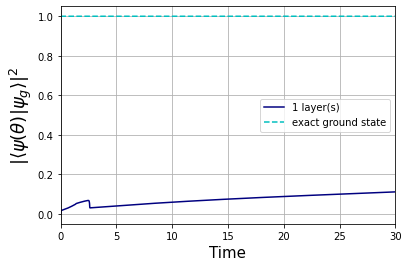

In [47]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,30)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_over_layers_5qutrits_M=0.1.pdf")

(0.0, 30.0)

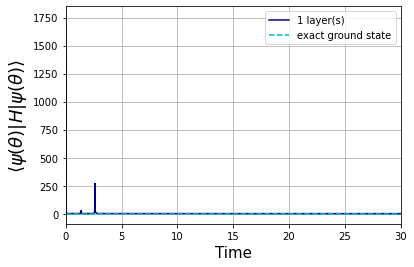

In [48]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,30)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_over_layers_5qutrits_M=0.1.pdf")

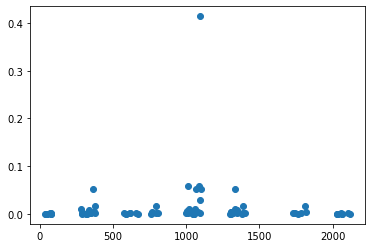

In [143]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvec[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

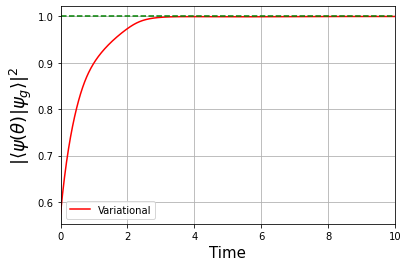

(0.0, 10.0)

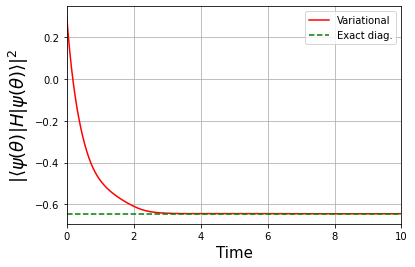

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
